# 1. Business Understanding
- Predict Remaining Useful Life (RUL) of engines for predictive maintenance.
- Reduce maintenance costs and prevent failures by accurate RUL prediction.

# 2. Data Understanding
- Load and explore the CMAPSS dataset.
- Summarize features, distributions, and missing values.

In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

In [27]:
# Defining feature names

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
                'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed',
                'Nf_dmd','PCNfR_dmd','W31','W32']

col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv('data/train_FD001.txt', sep=r"\s+", names=col_names, header=None)
df_test = pd.read_csv('data/test_FD001.txt', sep=r"\s+", names=col_names, header=None)
df_rul = pd.read_csv('data/RUL_FD001.txt', sep=r"\s+", header=None)


In [28]:
print(df_train.shape)
print(df_test.shape)
print(df_rul.shape)

(20631, 27)
(13096, 27)
(100, 1)


In [29]:
df_train

unit_number  time_cycles  setting_1  setting_2  setting_3     TRA  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

           T2      T24      T30    T50  ...      phi      NRf     NRc   BPR  \
0      641.82  1589.70  1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03   
1      642.15  1591.82  1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03   
2      642.35  1587.99  1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03   
3      642.35  1582.79  1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03   
4      642.37  1582.85  1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03   
...       ...      ...      ...    ...  ...      ...      ...     ...   ...   
20626  643.49  1597.98  1428.63  14.62  ...  2388.26  8137.60  8.4956  0.03   
20627  643.54  1604.50  1433.58  14.62  ...  2388.22  8136.50  8.5139  0.03   
20628  643.42  1602.46  1428.18  14.62  ...  2388.24  8141.05  8.5646  0.03   
20629  643.23  1605.26  1426.53  14.62  ...  2388.23  8139.29  8.5389  0.03   
20630  643.85  1600.38  1432.14  14.62  ...  2388.26  8137.33  8.5036  0.03   

       farB  htBleed  Nf_dmd  PCNfR_dmd      W31  W32  
0       392     2388   100.0      39.06  23.4190  NaN  
1       392     2388   100.0      39.00  23.4236  NaN  
2       390     2388   100.0      38.95  23.3442  NaN  
3       392     2388   100.0      38.88  23.3739  NaN  
4       393     2388   100.0      38.90  23.4044  NaN  
...     ...      ...     ...        ...      ...  ...  
20626   397     2388   100.0      38.49  22.9735  NaN  
20627   395     2388   100.0      38.30  23.1594  NaN  
20628   398     2388   100.0      38.44  22.9333  NaN  
20629   395     2388   100.0      38.29  23.0640  NaN  
20630   396     2388   100.0      38.37  23.0522  NaN  

[20631 rows x 27 columns]

In [30]:
df_test

unit_number  time_cycles  setting_1  setting_2  setting_3     TRA  \
0                1            1     0.0023     0.0003      100.0  518.67   
1                1            2    -0.0027    -0.0003      100.0  518.67   
2                1            3     0.0003     0.0001      100.0  518.67   
3                1            4     0.0042     0.0000      100.0  518.67   
4                1            5     0.0014     0.0000      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
13091          100          194     0.0049     0.0000      100.0  518.67   
13092          100          195    -0.0011    -0.0001      100.0  518.67   
13093          100          196    -0.0006    -0.0003      100.0  518.67   
13094          100          197    -0.0038     0.0001      100.0  518.67   
13095          100          198     0.0013     0.0003      100.0  518.67   

           T2      T24      T30    T50  ...      phi      NRf     NRc   BPR  \
0      643.02  1585.29  1398.21  14.62  ...  2388.03  8125.55  8.4052  0.03   
1      641.71  1588.45  1395.42  14.62  ...  2388.06  8139.62  8.3803  0.03   
2      642.46  1586.94  1401.34  14.62  ...  2388.03  8130.10  8.4441  0.03   
3      642.44  1584.12  1406.42  14.62  ...  2388.05  8132.90  8.3917  0.03   
4      642.51  1587.19  1401.92  14.62  ...  2388.03  8129.54  8.4031  0.03   
...       ...      ...      ...    ...  ...      ...      ...     ...   ...   
13091  643.24  1599.45  1415.79  14.62  ...  2388.00  8213.28  8.4715  0.03   
13092  643.22  1595.69  1422.05  14.62  ...  2388.09  8210.85  8.4512  0.03   
13093  643.44  1593.15  1406.82  14.62  ...  2388.04  8217.24  8.4569  0.03   
13094  643.26  1594.99  1419.36  14.62  ...  2388.08  8220.48  8.4711  0.03   
13095  642.95  1601.62  1424.99  14.62  ...  2388.05  8214.64  8.4903  0.03   

       farB  htBleed  Nf_dmd  PCNfR_dmd      W31  W32  
0       392     2388   100.0      38.86  23.3735  NaN  
1       393     2388   100.0      39.02  23.3916  NaN  
2       393     2388   100.0      39.08  23.4166  NaN  
3       391     2388   100.0      39.00  23.3737  NaN  
4       390     2388   100.0      38.99  23.4130  NaN  
...     ...      ...     ...        ...      ...  ...  
13091   394     2388   100.0      38.65  23.1974  NaN  
13092   395     2388   100.0      38.57  23.2771  NaN  
13093   395     2388   100.0      38.62  23.2051  NaN  
13094   395     2388   100.0      38.66  23.2699  NaN  
13095   396     2388   100.0      38.70  23.1855  NaN  

[13096 rows x 27 columns]

In [31]:
df_rul.columns = ['RUL']
df_rul

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [32]:
print('Total None values in the train dataset :')
print(df_train.isna().sum())

Total None values in the train dataset :
unit_number        0
time_cycles        0
setting_1          0
setting_2          0
setting_3          0
TRA                0
T2                 0
T24                0
T30                0
T50                0
P2                 0
P15                0
P30                0
Nf                 0
Nc                 0
epr                0
Ps30               0
phi                0
NRf                0
NRc                0
BPR                0
farB               0
htBleed            0
Nf_dmd             0
PCNfR_dmd          0
W31                0
W32            20631
dtype: int64


In [33]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

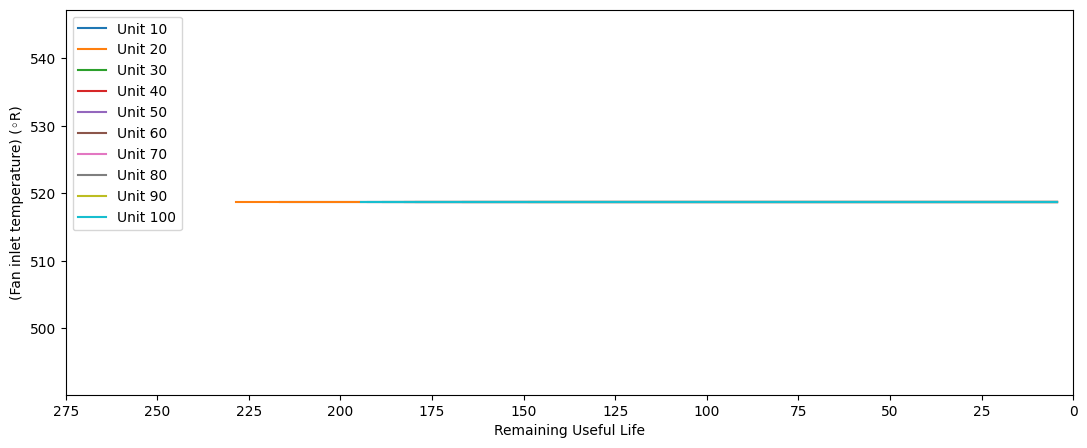

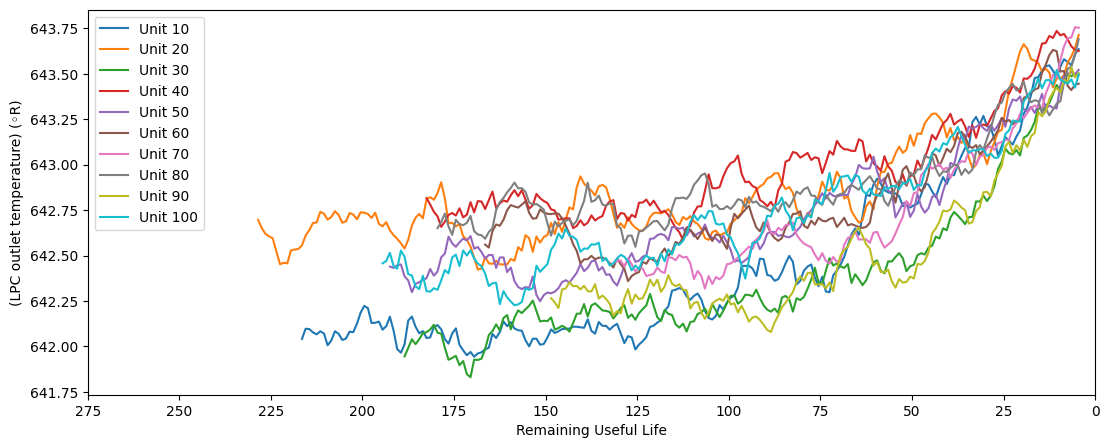

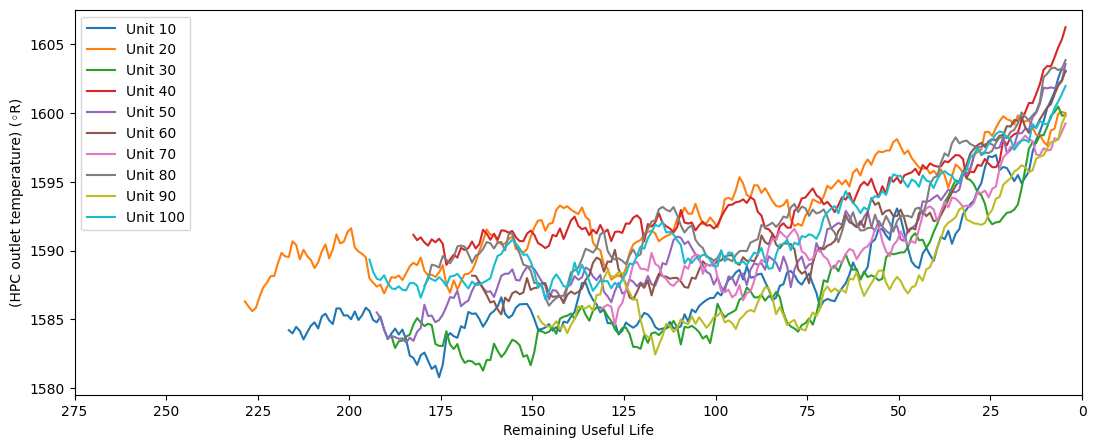

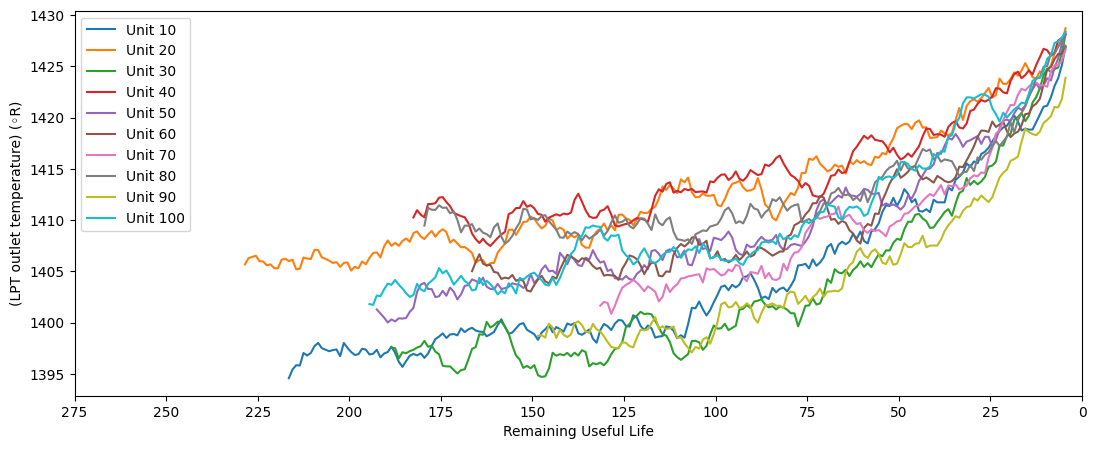

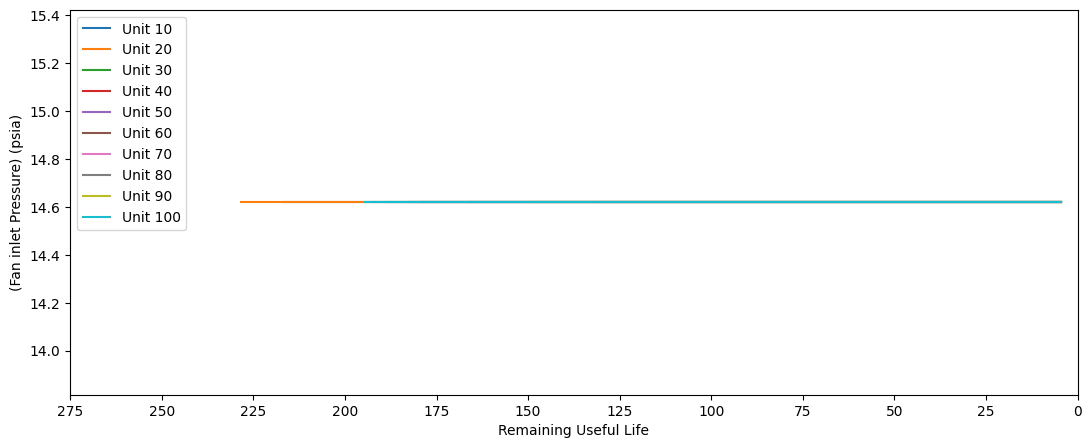

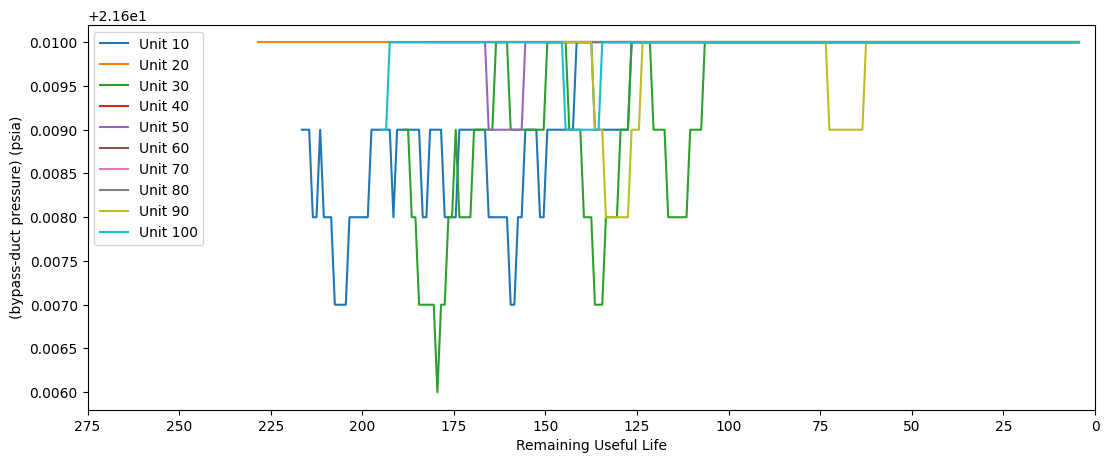

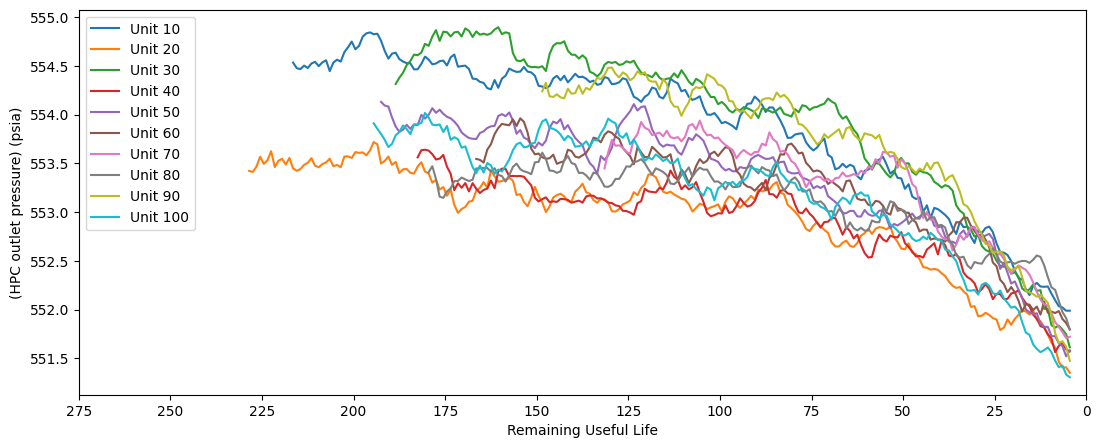

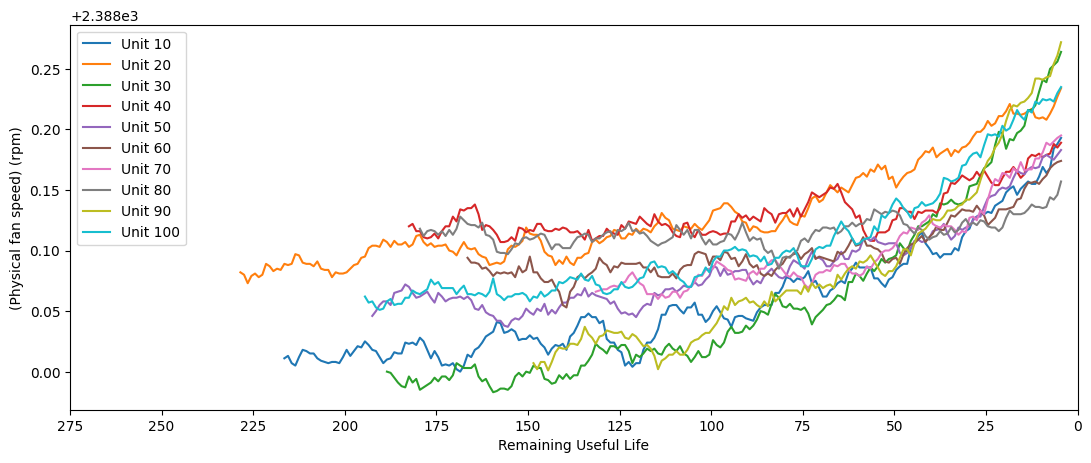

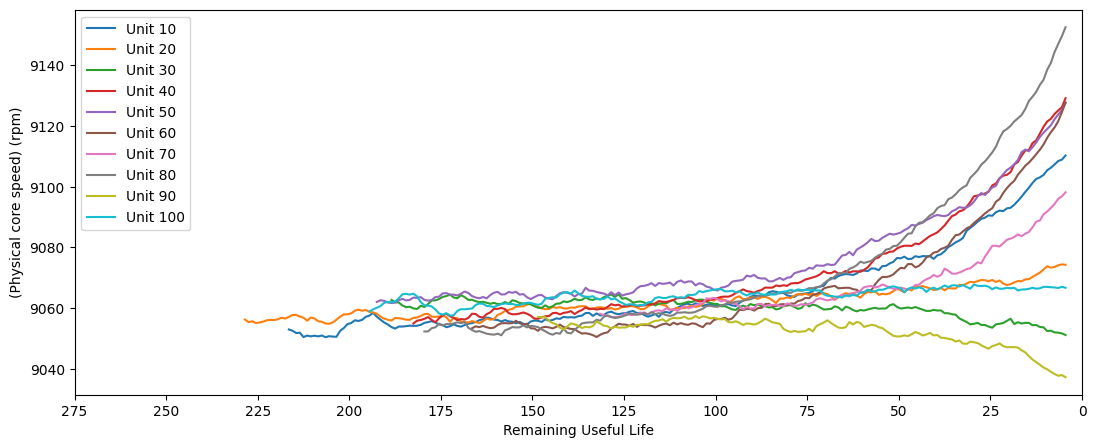

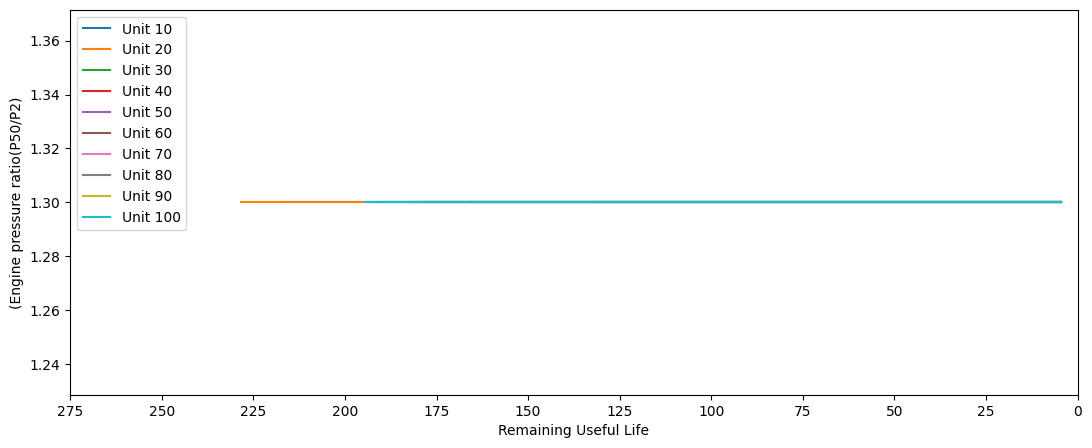

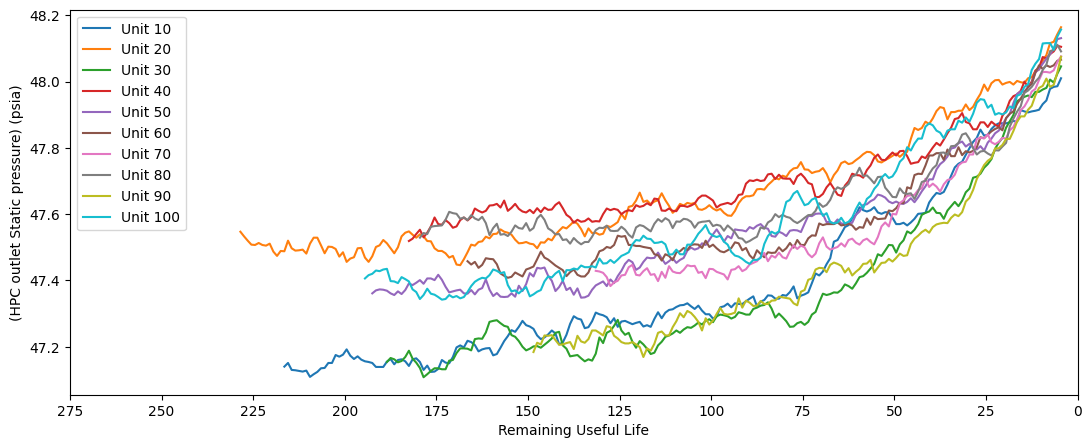

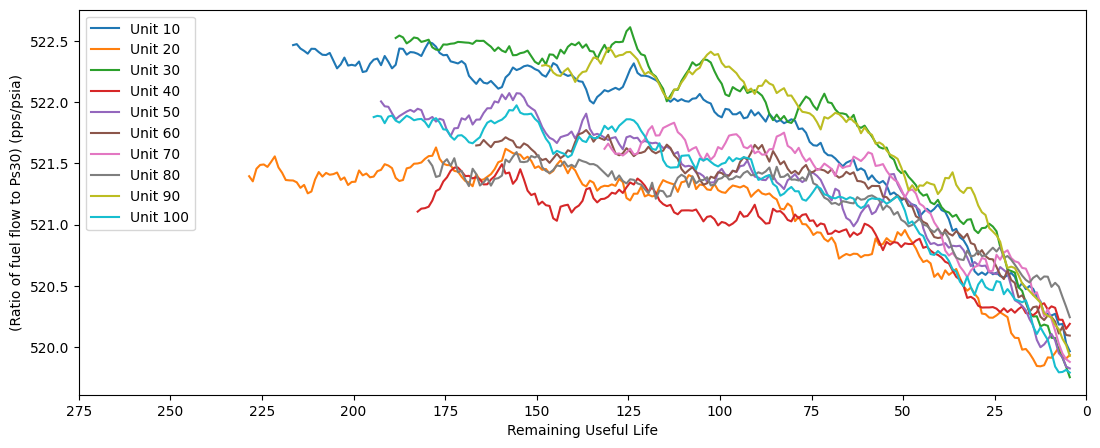

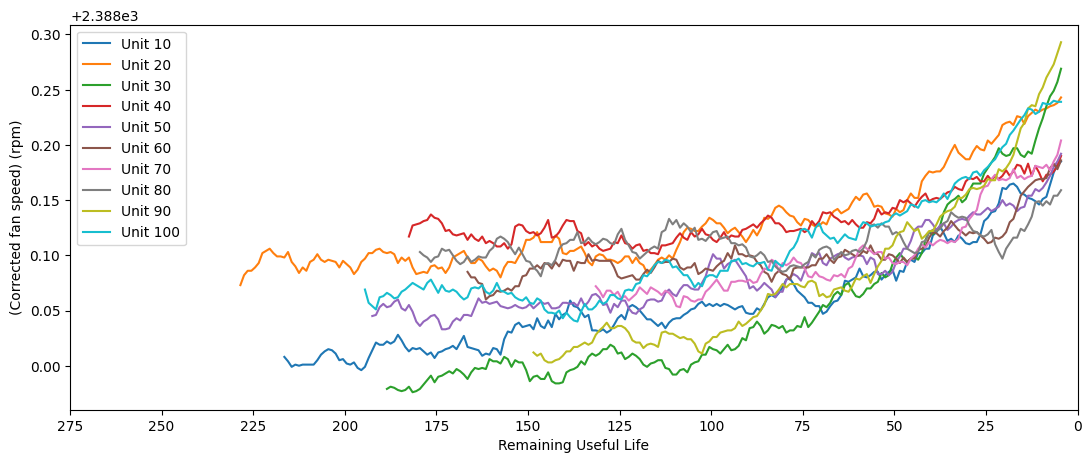

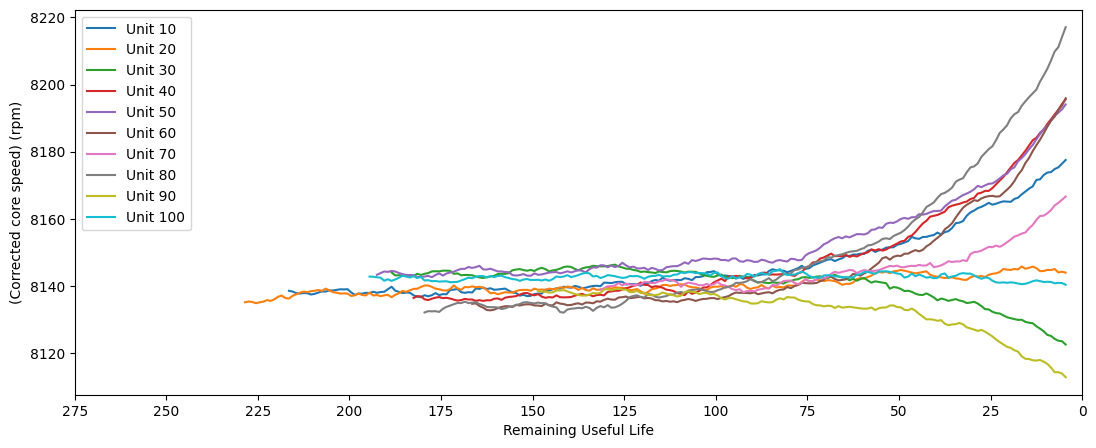

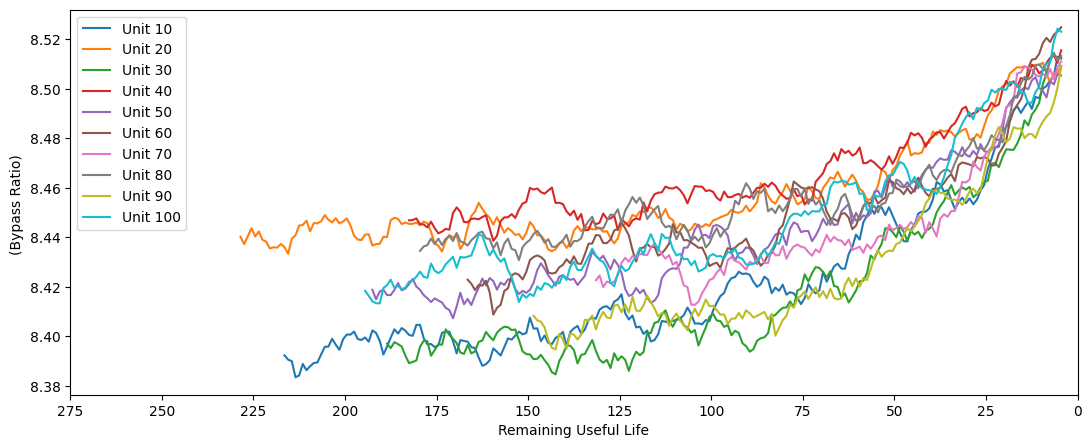

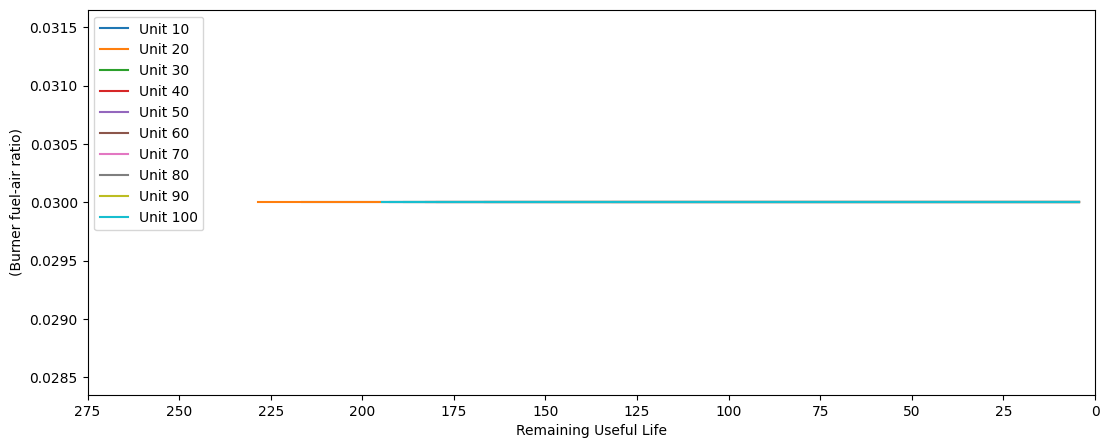

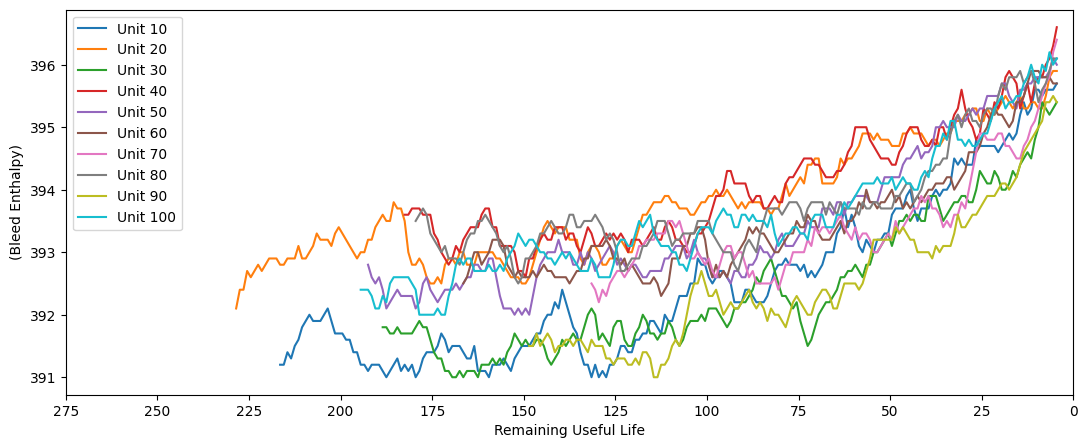

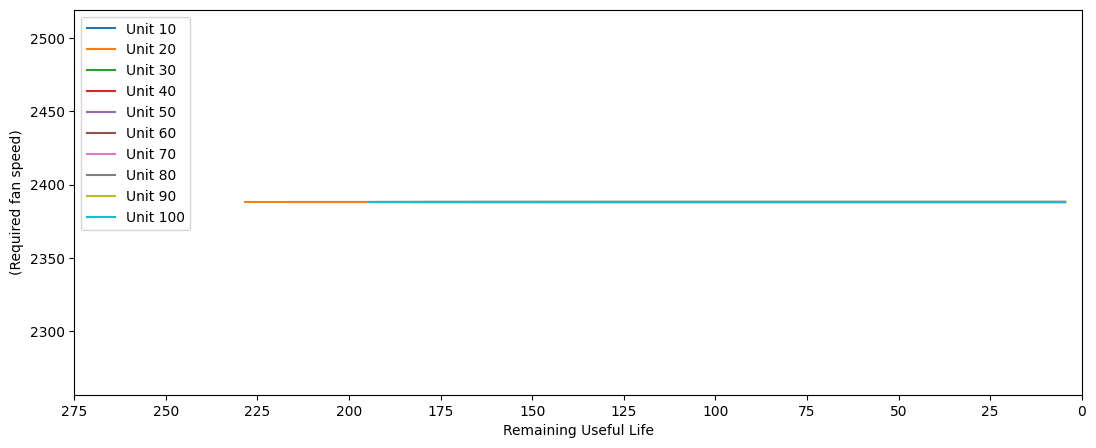

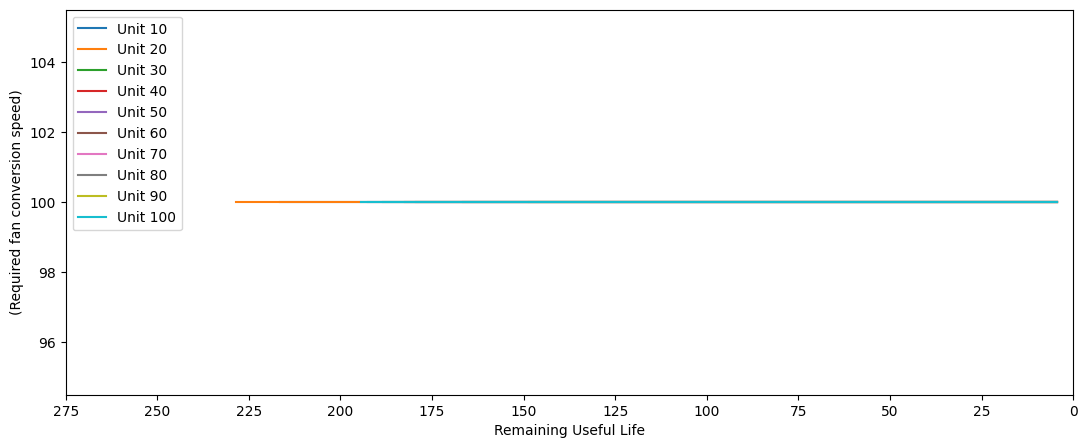

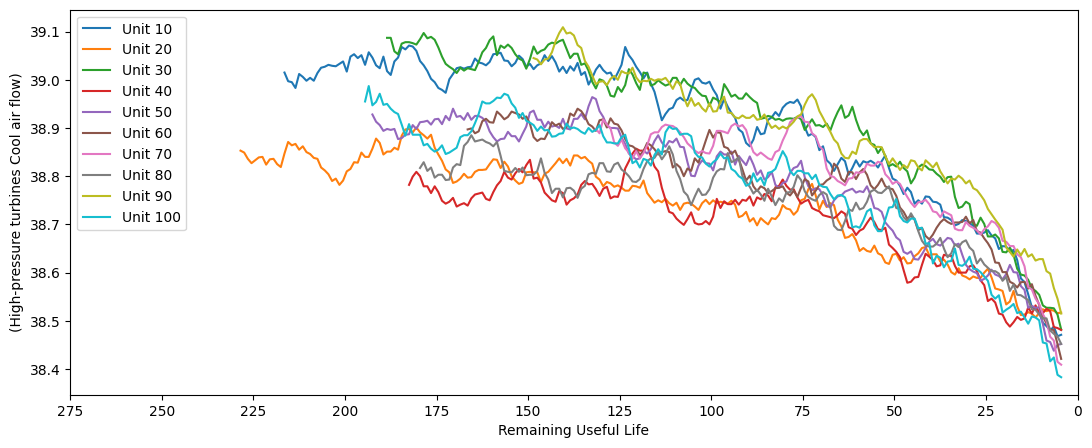

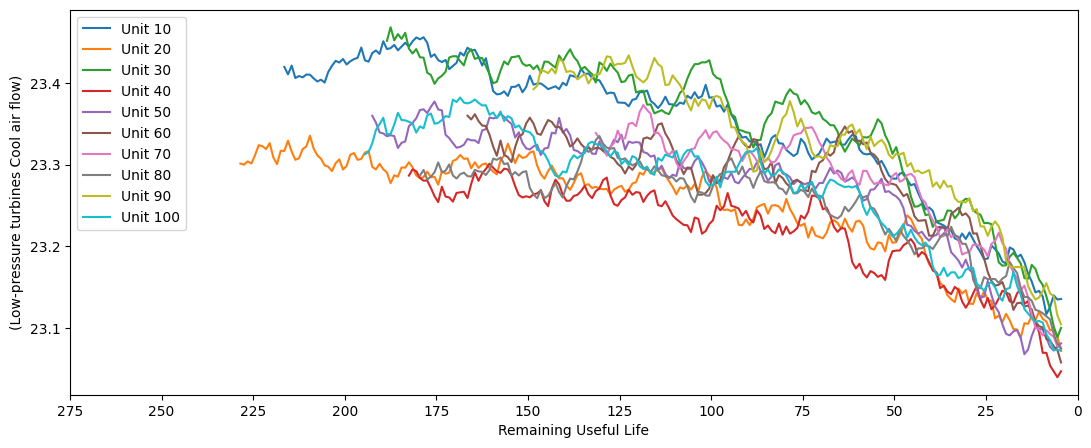

Failed for senor: 'W32'


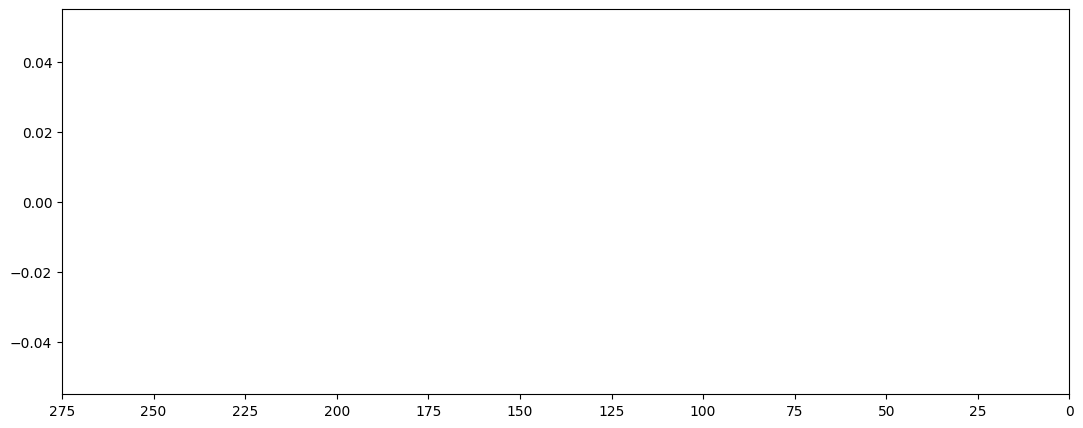

In [34]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 50

df_train['max_cycle'] = df_train.groupby('unit_number')['time_cycles'].transform('max')
df_train['RUL'] = df_train['max_cycle'] - df_train['time_cycles']
df_train = df_train.drop(columns='max_cycle')
Sensor_dictionary = dict(zip(sensor_names, dict_list))


def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   # For a better visualisation, plot only some units
            plt.plot(
                df[df['unit_number']==i]['RUL'].rolling(10).mean(),
                df[df['unit_number']==i][signal_name].rolling(10).mean(),
                label=f'Unit {i}'
            )
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.legend()
    plt.show()
    plt.close()


for sensor in sensor_names:
    try:
        plot_signal(df_train, Sensor_dictionary, sensor)
    except Exception as e:
        print(f"Failed for senor: {e}")

In [35]:
df_train.loc[:,:].describe().transpose()

count         mean           std        min        25%  \
unit_number  20631.0    51.506568  2.922763e+01     1.0000    26.0000   
time_cycles  20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting_1    20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting_2    20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting_3    20631.0   100.000000  0.000000e+00   100.0000   100.0000   
TRA          20631.0   518.670000  0.000000e+00   518.6700   518.6700   
T2           20631.0   642.680934  5.000533e-01   641.2100   642.3250   
T24          20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
T30          20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
T50          20631.0    14.620000  1.776400e-15    14.6200    14.6200   
P2           20631.0    21.609803  1.388985e-03    21.6000    21.6100   
P15          20631.0   553.367711  8.850923e-01   549.8500   552.8100   
P30          20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
Nf           20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
Nc           20631.0     1.300000  0.000000e+00     1.3000     1.3000   
epr          20631.0    47.541168  2.670874e-01    46.8500    47.3500   
Ps30         20631.0   521.413470  7.375534e-01   518.6900   520.9600   
phi          20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
NRf          20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
NRc          20631.0     8.442146  3.750504e-02     8.3249     8.4149   
BPR          20631.0     0.030000  1.387812e-17     0.0300     0.0300   
farB         20631.0   393.210654  1.548763e+00   388.0000   392.0000   
htBleed      20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
Nf_dmd       20631.0   100.000000  0.000000e+00   100.0000   100.0000   
PCNfR_dmd    20631.0    38.816271  1.807464e-01    38.1400    38.7000   
W31          20631.0    23.289705  1.082509e-01    22.8942    23.2218   
W32              0.0          NaN           NaN        NaN        NaN   
RUL          20631.0   107.807862  6.888099e+01     0.0000    51.0000   

                   50%        75%        max  
unit_number    52.0000    77.0000   100.0000  
time_cycles   104.0000   156.0000   362.0000  
setting_1       0.0000     0.0015     0.0087  
setting_2       0.0000     0.0003     0.0006  
setting_3     100.0000   100.0000   100.0000  
TRA           518.6700   518.6700   518.6700  
T2            642.6400   643.0000   644.5300  
T24          1590.1000  1594.3800  1616.9100  
T30          1408.0400  1414.5550  1441.4900  
T50            14.6200    14.6200    14.6200  
P2             21.6100    21.6100    21.6100  
P15           553.4400   554.0100   556.0600  
P30          2388.0900  2388.1400  2388.5600  
Nf           9060.6600  9069.4200  9244.5900  
Nc              1.3000     1.3000     1.3000  
epr            47.5100    47.7000    48.5300  
Ps30          521.4800   521.9500   523.3800  
phi          2388.0900  2388.1400  2388.5600  
NRf          8140.5400  8148.3100  8293.7200  
NRc             8.4389     8.4656     8.5848  
BPR             0.0300     0.0300     0.0300  
farB          393.0000   394.0000   400.0000  
htBleed      2388.0000  2388.0000  2388.0000  
Nf_dmd        100.0000   100.0000   100.0000  
PCNfR_dmd      38.8300    38.9500    39.4300  
W31            23.2979    23.3668    23.6184  
W32                NaN        NaN        NaN  
RUL           103.0000   155.0000   361.0000



Data Insights

- corr plot shows features with high correlation (dark green) are more predictive of RUL. For example, s11, s12, s4, s7, s17, and s21 show strong correlation in FD001 and FD003.
-  Features with low correlation (light yellow/white) are less useful for RUL prediction. Many operational settings (op_1, op_2, op_3) and some sensors (s1, s5, s10, s18, s19) have very low correlation across all datasets.
- each feature varies by dataset. For instance, s11 is highly correlated with RUL in FD001 and FD003, but not in FD002 or FD004.
- Features with consistently low correlation (e.g., s1, s5, s10, s18, s19) can be dropped, since they don't influence to RUL prediction
- plots show that sensors 1,5,10,16,18,19 are constant. Hence they don't influence the RUL, we can drop those later
- W32 sensor contains entire null values, shall drop it
-  the statistic properties of sensors data show that they don't have the same scale and they don't follow a normal distribution, will need to use minMax or z score

# 3. Data Preparation
- Clean data
- engineer features
- scale values
- create time windows for modeling.

In [36]:

# variable for column names
# three operating‑setting cols and 21 sensors
COLS = (
    ["unit", "cycle"] +
    [f"op_{i}" for i in range(1, 4)] +          
    [f"s{i}" for i in range(1, 22)]             
)



def read_raw(file_path):
    """
    Loader for CMAPSS turbofan datasets txt file into a DataFrame with column names.
    Returns the raw DataFrame exactly as in the file (no RUL, no scaling).
    """
    df = pd.read_csv(file_path, sep=r"\s+", header=None)
    df.dropna(axis=1, inplace=True)
    df.columns = COLS[: df.shape[1]]      
    return df


df_train_fd001 = read_raw("data/train_FD001.txt")
df_train_fd002 = read_raw("data/train_FD002.txt")
df_train_fd003 = read_raw("data/train_FD003.txt")
df_train_fd004 = read_raw("data/train_FD004.txt")

In [37]:
def _attach_rul(df):
    """
    Append Remaining Useful Life (RUL) column to df.
    """
    max_cycle = df.groupby("unit")["cycle"].max().rename("max_cycle")
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    return df.drop(columns="max_cycle")


df_train_fd001 = _attach_rul(df_train_fd001)
df_train_fd002 = _attach_rul(df_train_fd002)
df_train_fd003 = _attach_rul(df_train_fd003)
df_train_fd004 = _attach_rul(df_train_fd004)

In [38]:
def cap_rul(df, cap):
    """Cap the RUL at a maximum value."""
    df = df.copy()
    if "RUL" not in df.columns:
        raise KeyError("DataFrame must contain 'RUL' column")
    df["RUL"] = df["RUL"].clip(upper=cap)
    return df



df_train_fd001 = cap_rul(df_train_fd001, cap=125)
df_train_fd002 = cap_rul(df_train_fd002, cap=125)
df_train_fd003 = cap_rul(df_train_fd003, cap=125)
df_train_fd004 = cap_rul(df_train_fd004, cap=125)


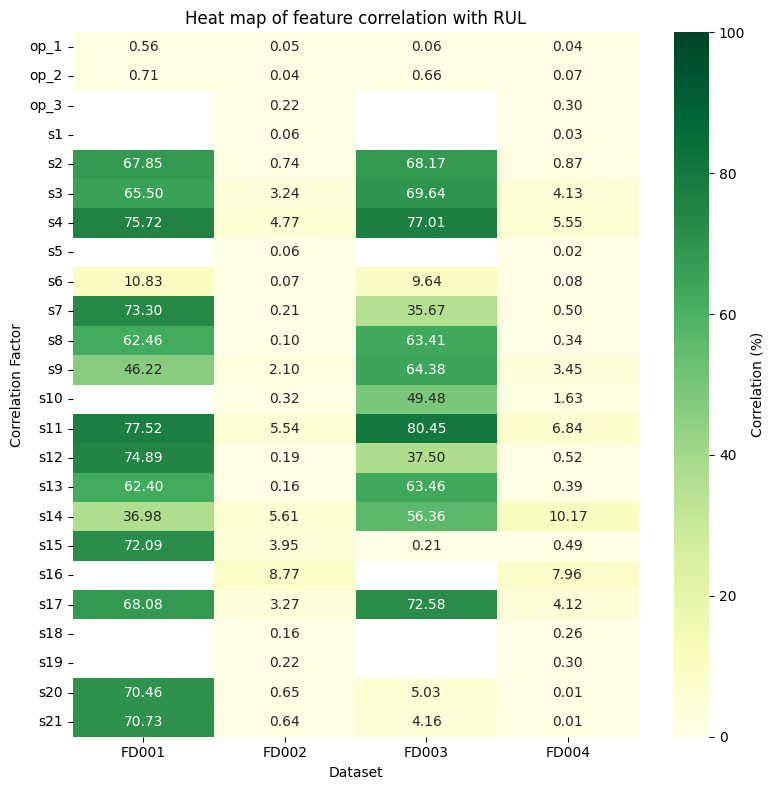

FD001 selected features: ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
FD002 selected features: ['op_1', 'op_2', 'op_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
FD003 selected features: ['s2', 's3', 's4', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's17']
FD004 selected features: ['op_1', 'op_2', 'op_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def correlation_feature_selection(df, feature_cols, target_col='RUL', threshold=0.1):
    """
    Select features based on absolute correlation with RUL.
    Returns a list of selected features and the correlation series.
    """
    corrs = df[feature_cols + [target_col]].corr()[target_col].drop(target_col)
    selected = corrs[abs(corrs) >= threshold].index.tolist()
    return selected, corrs

def plot_correlation_heatmaps(corrs_dict, feature_order=None):
    """
    Plot a vertical heatmap of feature correlations (as %) for multiple datasets.
    """
    corrs_df = pd.DataFrame({k: v.abs() * 100 for k, v in corrs_dict.items()})
    if feature_order is not None:
        corrs_df = corrs_df.reindex(feature_order)
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".2f",
        cmap="YlGn",
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Correlation (%)'}
    )
    plt.title("Heat map of feature correlation with RUL")
    plt.ylabel("Correlation Factor")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()







# List of all feature columns (excluding 'unit', 'cycle', 'RUL')
all_feature_cols = [f"op_{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]

# Sensor Selection Criteria
selected_features_001, corrs_001 = correlation_feature_selection(df_train_fd001, all_feature_cols, threshold=0.10)
selected_features_002, corrs_002 = correlation_feature_selection(df_train_fd002, all_feature_cols, threshold=0.0001)
selected_features_003, corrs_003 = correlation_feature_selection(df_train_fd003, all_feature_cols, threshold=0.10)
selected_features_004, corrs_004 = correlation_feature_selection(df_train_fd004, all_feature_cols, threshold=0.0001)


# Store for plotting
feature_order = [f"op_{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
corrs_dict = {
    'FD001': corrs_001,
    'FD002': corrs_002,
    'FD003': corrs_003,
    'FD004': corrs_004,
}
plot_correlation_heatmaps(corrs_dict, feature_order)

# selected features
print("FD001 selected features:", selected_features_001)
print("FD002 selected features:", selected_features_002)
print("FD003 selected features:", selected_features_003)
print("FD004 selected features:", selected_features_004)




In [40]:
import pandas as pd

def apply_median_filter(df, feature_cols, window_size=5):
    """
    Apply a moving median filter to each feature column per engine unit.
    Returns a new DataFrame with filtered sensor data.
    """
    df_filtered = df.copy()
    for col in feature_cols:
        # Apply median filter per engine unit
        df_filtered[col] = (
            df.groupby('unit')[col]
            .transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median())
        )
    return df_filtered

df_train_fd001_filter = apply_median_filter(df_train_fd001, selected_features_001, window_size=5)
df_train_fd002_filter = apply_median_filter(df_train_fd002, selected_features_002, window_size=5)
df_train_fd003_filter = apply_median_filter(df_train_fd003, selected_features_003, window_size=5)
df_train_fd004_filter = apply_median_filter(df_train_fd004, selected_features_004, window_size=5)



In [41]:
def split_by_unit(df_scaled, val_ratio=0.2, random_state=42):
    """
    Splits the DataFrame into train and validation sets based on unique engine units.
    Returns train_df, val_df.
    """
    all_units = df_scaled["unit"].unique()
    train_units, val_units = train_test_split(
        all_units,
        test_size=val_ratio,
        random_state=random_state,
    )
    train_df = df_scaled[df_scaled.unit.isin(train_units)]
    val_df   = df_scaled[df_scaled.unit.isin(val_units)]
    return train_df, val_df


fd001_train_df, fd001_val_df = split_by_unit(df_train_fd001)
fd002_train_df, fd002_val_df = split_by_unit(df_train_fd002)
fd003_train_df, fd003_val_df = split_by_unit(df_train_fd003)
fd004_train_df, fd004_val_df = split_by_unit(df_train_fd004)

In [42]:
def scale_train_val(train_df, val_df):
    """
    Fits a MinMaxScaler on train_df[feature_cols], then transforms both dataframes.
    Returns (train_scaled, val_scaled, feature_cols, scaler).
    """
    # features (omitting 'unit','cycle' and 'RUL')
    feature_cols = list(train_df.columns[2:-1])
    
    scaler = MinMaxScaler()
    train_scaled = train_df.copy()
    train_scaled[feature_cols] = scaler.fit_transform(train_scaled[feature_cols])
    
    val_scaled = val_df.copy()
    val_scaled[feature_cols] = scaler.transform(val_scaled[feature_cols])
    
    return train_scaled, val_scaled, feature_cols, scaler



df_tr_scaled_001, df_val_scaled_001, feat_cols_001, scaler_001 = scale_train_val(fd001_train_df, fd001_val_df)
df_tr_scaled_002, df_val_scaled_002, feat_cols_002, scaler_002 = scale_train_val(fd002_train_df, fd002_val_df) 
df_tr_scaled_003, df_val_scaled_003, feat_cols_003, scaler_003 = scale_train_val(fd003_train_df, fd003_val_df)
df_tr_scaled_004, df_val_scaled_004, feat_cols_004, scaler_004 = scale_train_val(fd004_train_df, fd004_val_df)     


In [ ]:
import joblib
from pathlib import Path

Path("checkpoints").mkdir(exist_ok=True)

joblib.dump(scaler_001, "checkpoints/scaler_FD001.bin")
joblib.dump(scaler_002, "checkpoints/scaler_FD002.bin")
joblib.dump(scaler_003, "checkpoints/scaler_FD003.bin")
joblib.dump(scaler_004, "checkpoints/scaler_FD004.bin")

['checkpoints/scaler_FD004.bin']

In [44]:
def window_slice(
    df,
    window,
    stride,
    feature_cols,
    target_col: str = "RUL"):
    """
    Convert per-unit time-series DataFrame into fixed-length windows.
    If target_col not in df, only returns 'x' and 'domain'.
    """
    has_target = (target_col is not None and target_col in df.columns)
    if feature_cols is None:
        feature_cols = (
            list(df.columns[2:-1]) if has_target else list(df.columns[2:])
        )

    xs, ys, domains = [], [], []

    for unit_id, grp in df.groupby("unit", sort=False):
        grp = grp.sort_values("cycle")
        feats = grp[feature_cols].values.astype("float32")
        if has_target:
            tars = grp[target_col].values.astype("float32")

        # padding short sequences on the left
        n = feats.shape[0]
        if n < window:
            pad_len = window - n
            feats = np.vstack(
                [np.zeros((pad_len, feats.shape[1]), dtype="float32"), feats]
            )
            if has_target:
                tars = np.concatenate(
                    [np.full(pad_len, tars[0], dtype="float32"), tars]
                )

        # slicing windows
        for start in range(0, feats.shape[0] - window + 1, stride):
            end = start + window
            xs.append(feats[start:end])
            if has_target:
                ys.append(tars[end - 1])
            domains.append(unit_id)

    # (N_windows, window, F)
    result = {
        "x": np.stack(xs),                         
        "domain": np.array(domains, dtype="int64"),
    }
    if has_target:
        result["y"] = np.array(ys, dtype="float32")
    return result



# dictionary to hold windowed data for each FD00x dataset
domain_packs = {}

# Loop over each dataset code
for domain in ['001', '002', '003', '004']:
    
    train_df     = globals()[f'df_tr_scaled_{domain}']
    val_df       = globals()[f'df_val_scaled_{domain}']
    feature_cols = globals()[f'feat_cols_{domain}']
    
    # Window-slicing
    train_pack = window_slice(
        train_df,
        window=30,
        stride=1,
        feature_cols=feature_cols
    )
    val_pack = window_slice(
        val_df,
        window=30,
        stride=1,
        feature_cols=feature_cols
    )
    
    # Store the resulting arrays in our domain_packs dict 
    #    - 'x':      feature tensor of shape (N_windows, Tw, F)
    #    - 'y':      target RUL values, shape (N_windows,)
    #    - 'domain': original unit IDs, shape (N_windows,)
    domain_packs[f'FD{domain}'] = {
        'train': {
            'x':      train_pack['x'],
            'y':      train_pack['y'],
            'domain': train_pack['domain'],
        },
        'val': {
            'x':      val_pack['x'],
            'y':      val_pack['y'],
            'domain': val_pack['domain'],
        }
    }
    
    print(f"FD{domain} → train windows {train_pack['x'].shape}, domains {train_pack['domain'].shape}")
    print(f"         val   windows {val_pack['x'].shape}, domains {val_pack['domain'].shape}")

FD001 → train windows (14241, 30, 24), domains (14241,)
         val   windows (3490, 30, 24), domains (3490,)
FD002 → train windows (37432, 30, 24), domains (37432,)
         val   windows (8787, 30, 24), domains (8787,)
FD003 → train windows (17692, 30, 24), domains (17692,)
         val   windows (4128, 30, 24), domains (4128,)
FD004 → train windows (43523, 30, 24), domains (43523,)
         val   windows (10505, 30, 24), domains (10505,)


In [ ]:
batch_size = 256
num_workers = 4

dataloaders = {}

for domain_code, packs in domain_packs.items():

    x_tr_np, y_tr_np, d_tr_np = (
        packs['train']['x'],
        packs['train']['y'],
        packs['train']['domain'],
    )
    x_val_np, y_val_np, d_val_np = (
        packs['val']['x'],
        packs['val']['y'],
        packs['val']['domain'],
    )

    x_tr = torch.tensor(x_tr_np, dtype=torch.float32)
    y_tr = torch.tensor(y_tr_np, dtype=torch.float32)
    d_tr = torch.tensor(d_tr_np, dtype=torch.long)

    x_val = torch.tensor(x_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.float32)
    d_val = torch.tensor(d_val_np, dtype=torch.long)

    train_ds = TensorDataset(x_tr, y_tr, d_tr)
    val_ds   = TensorDataset(x_val, y_val, d_val)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, drop_last=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, drop_last=True, pin_memory=True
    )

    dataloaders[domain_code] = {'train': train_loader, 'val': val_loader}
    print(f"{domain_code}: {len(train_loader)} train batches, {len(val_loader)} val batches")


FD001: 55 train batches, 13 val batches
FD002: 146 train batches, 34 val batches
FD003: 69 train batches, 16 val batches
FD004: 170 train batches, 41 val batches


# 4. Modeling
- Build and train LSTM and DANN models for RUL prediction.
- Tune hyperparameters and select model architecture.

#### Experiment 1 - Same Domain using baseline Batch Norm LSTM

  - Train on individual models on train_FD001, FD002, FD003, FD004  
  - Evaluate ground truth RUL values on their respective test on test_FD002, test_FD003, test_FD004

In [46]:

# baseline LSTM regressor with BatchNorm on the hidden state
class LstmRegressorBN(nn.Module):
    def __init__(self, input_dim, hidden=100, n_layers=1, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        # BatchNorm over the hidden dimension
        self.bn = nn.BatchNorm1d(hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, 30),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(30, 1)
        )

    def forward(self, x):
        # x: (B, Tw, F)
        _, (h_n, _) = self.lstm(x)
        hidden = h_n[-1]             
        hidden_bn = self.bn(hidden)  
        out = self.head(hidden_bn)   
        return out.squeeze(1)         

In [86]:

def train_target_domain(domain_code, n_epochs=100, patience=20, batch_size=256, 
                       window_size=30, learning_rate=1e-3, device='cuda'):
    """
    Train a model on a specific domain and save the best checkpoint.
    """
    print(f"\n=== Training Target-Only Model for {domain_code} ===")
    
    # dataloader for current domain
    train_loader = dataloaders[domain_code]['train']
    val_loader = dataloaders[domain_code]['val']
    
    # Initialize model
    input_dim = next(iter(train_loader))[0].shape[-1]
    model = LstmRegressorBN(input_dim=input_dim, 
                           hidden=100, 
                           n_layers=1, 
                           dropout=0.5).to(device)
    
    criterion = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                 patience=5, verbose=True)
    
    # Training loop
    best_rmse = float('inf')
    stall = 0
    
    for epoch in range(1, n_epochs + 1):
        # Training phase
        model.train()
        for xb, yb, _ in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
        # Validation phase
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb, _ in val_loader:
                xb = xb.to(device)
                preds = model(xb).cpu()
                val_preds.append(preds)
                val_targets.append(yb)
                
        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)
        rmse = torch.sqrt(torch.mean((val_preds - val_targets) ** 2)).item()
        
        print(f"Epoch {epoch:03d} | Val RMSE: {rmse:.3f}")
        scheduler.step(rmse)
        
        # Checkpoint saving
        if rmse < best_rmse:
            best_rmse = rmse
            stall = 0
            torch.save(model.state_dict(), 
                      f"checkpoints/best_{domain_code}_target.pt")
        else:
            stall += 1
            if stall >= patience:
                print("Early stopping triggered.")
                break
    
    return f"checkpoints/best_{domain_code}_target.pt"






def evaluate_target_domain(domain_code, checkpoint_path):
    """
    Evaluate a trained model on its corresponding test set.
    """
    # Load test data
    test_df = read_raw(Path("data/") / f"test_{domain_code}.txt")
    true_rul = np.loadtxt(Path("data/") / f"RUL_{domain_code}.txt")
    
    # Get domain-specific scaler and features
    scaler = globals()[f"scaler_{domain_code[-3:]}"]
    feature_cols = globals()[f"feat_cols_{domain_code[-3:]}"]
    
    # Scale test data
    test_scaled = test_df.copy()
    test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
    
    # Window slice
    windows = window_slice(test_scaled, window=30, 
                         stride=1, feature_cols=feature_cols)
    
    # Get last window for each unit
    units = windows['domain']
    unique_units = np.unique(units)
    last_indices = [np.where(units == unit)[0][-1] for unit in unique_units]
    X_last = windows['x'][last_indices]
    
    # Load model and predict
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LstmRegressorBN(input_dim=len(feature_cols), 
                           hidden=100, 
                           n_layers=1, 
                           dropout=0.5).to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    
    # Make predictions
    X_last = torch.FloatTensor(X_last).to(device)
    with torch.no_grad():
        predictions = model(X_last).cpu().numpy()
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((predictions - true_rul) ** 2))
    h = predictions - true_rul
    nasa_score = np.mean(np.where(h < 0, 
                                 np.exp(-h/13) - 1, 
                                 np.exp(h/10) - 1))
    
    return {
        'domain': domain_code,
        'rmse': rmse,
        'nasa_score': nasa_score,
        'predictions': predictions,
        'true_rul': true_rul
    }

# Train and evaluate all domains
if __name__ == "__main__":
    # Create checkpoints directory
    Path("checkpoints").mkdir(exist_ok=True)
    
    # Results storage
    all_results = {}
    
    # Train and evaluate each domain
    for domain in ['FD001', 'FD002', 'FD003', 'FD004']:
        print(f"\nProcessing {domain}")
        
        # Train model and get checkpoint path
        ckpt_path = train_target_domain(domain)
        
        # Evaluate on test set
        results = evaluate_target_domain(domain, ckpt_path)
        all_results[domain] = results
        
        print(f"\n{domain} Test Results:")
        print(f"RMSE: {results['rmse']:.3f}")
        print(f"NASA Score: {results['nasa_score']:.1f}")
    



Processing FD001

=== Training Target-Only Model for FD001 ===


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 86.205
Epoch 002 | Val RMSE: 79.698
Epoch 003 | Val RMSE: 69.089
Epoch 004 | Val RMSE: 54.174
Epoch 005 | Val RMSE: 65.531
Epoch 006 | Val RMSE: 50.844
Epoch 007 | Val RMSE: 35.274
Epoch 008 | Val RMSE: 56.529
Epoch 009 | Val RMSE: 38.785
Epoch 010 | Val RMSE: 35.211
Epoch 011 | Val RMSE: 59.554
Epoch 012 | Val RMSE: 31.517
Epoch 013 | Val RMSE: 56.908
Epoch 014 | Val RMSE: 14.476
Epoch 015 | Val RMSE: 16.382
Epoch 016 | Val RMSE: 32.941
Epoch 017 | Val RMSE: 19.076
Epoch 018 | Val RMSE: 14.075
Epoch 019 | Val RMSE: 14.066
Epoch 020 | Val RMSE: 15.021
Epoch 021 | Val RMSE: 20.524
Epoch 022 | Val RMSE: 23.592
Epoch 023 | Val RMSE: 15.163
Epoch 024 | Val RMSE: 14.647
Epoch 025 | Val RMSE: 20.215
Epoch 026 | Val RMSE: 13.143
Epoch 027 | Val RMSE: 12.692
Epoch 028 | Val RMSE: 12.680
Epoch 029 | Val RMSE: 14.751
Epoch 030 | Val RMSE: 12.851
Epoch 031 | Val RMSE: 12.509
Epoch 032 | Val RMSE: 17.053
Epoch 033 | Val RMSE: 14.696
Epoch 034 | Val RMSE: 12.422
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\2830216927.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



FD001 Test Results:
RMSE: 14.566
NASA Score: 3.6

Processing FD002

=== Training Target-Only Model for FD002 ===


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 62.377
Epoch 002 | Val RMSE: 59.898
Epoch 003 | Val RMSE: 48.567
Epoch 004 | Val RMSE: 22.684
Epoch 005 | Val RMSE: 22.059
Epoch 006 | Val RMSE: 37.300
Epoch 007 | Val RMSE: 23.029
Epoch 008 | Val RMSE: 26.839
Epoch 009 | Val RMSE: 24.494
Epoch 010 | Val RMSE: 30.114
Epoch 011 | Val RMSE: 20.520
Epoch 012 | Val RMSE: 20.234
Epoch 013 | Val RMSE: 22.815
Epoch 014 | Val RMSE: 22.411
Epoch 015 | Val RMSE: 19.557
Epoch 016 | Val RMSE: 19.686
Epoch 017 | Val RMSE: 21.023
Epoch 018 | Val RMSE: 18.921
Epoch 019 | Val RMSE: 18.901
Epoch 020 | Val RMSE: 18.802
Epoch 021 | Val RMSE: 17.895
Epoch 022 | Val RMSE: 19.030
Epoch 023 | Val RMSE: 18.182
Epoch 024 | Val RMSE: 20.024
Epoch 025 | Val RMSE: 20.078
Epoch 026 | Val RMSE: 20.486
Epoch 027 | Val RMSE: 19.450
Epoch 028 | Val RMSE: 17.451
Epoch 029 | Val RMSE: 17.462
Epoch 030 | Val RMSE: 20.166
Epoch 031 | Val RMSE: 20.163
Epoch 032 | Val RMSE: 16.919
Epoch 033 | Val RMSE: 17.562
Epoch 034 | Val RMSE: 18.658
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\2830216927.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



FD002 Test Results:
RMSE: 30.740
NASA Score: 131.4

Processing FD003

=== Training Target-Only Model for FD003 ===


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 87.736
Epoch 002 | Val RMSE: 72.620
Epoch 003 | Val RMSE: 65.771
Epoch 004 | Val RMSE: 53.176
Epoch 005 | Val RMSE: 35.386
Epoch 006 | Val RMSE: 116.641
Epoch 007 | Val RMSE: 24.563
Epoch 008 | Val RMSE: 25.049
Epoch 009 | Val RMSE: 47.927
Epoch 010 | Val RMSE: 22.790
Epoch 011 | Val RMSE: 18.112
Epoch 012 | Val RMSE: 25.386
Epoch 013 | Val RMSE: 20.658
Epoch 014 | Val RMSE: 26.774
Epoch 015 | Val RMSE: 14.186
Epoch 016 | Val RMSE: 14.327
Epoch 017 | Val RMSE: 19.583
Epoch 018 | Val RMSE: 16.940
Epoch 019 | Val RMSE: 15.111
Epoch 020 | Val RMSE: 20.113
Epoch 021 | Val RMSE: 18.497
Epoch 022 | Val RMSE: 14.047
Epoch 023 | Val RMSE: 16.197
Epoch 024 | Val RMSE: 14.198
Epoch 025 | Val RMSE: 14.468
Epoch 026 | Val RMSE: 13.479
Epoch 027 | Val RMSE: 15.952
Epoch 028 | Val RMSE: 13.334
Epoch 029 | Val RMSE: 14.116
Epoch 030 | Val RMSE: 13.509
Epoch 031 | Val RMSE: 13.055
Epoch 032 | Val RMSE: 15.527
Epoch 033 | Val RMSE: 12.183
Epoch 034 | Val RMSE: 12.996
Epoch 035 | V

C:\Users\House\AppData\Local\Temp\ipykernel_25400\2830216927.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



FD003 Test Results:
RMSE: 13.659
NASA Score: 3.2

Processing FD004

=== Training Target-Only Model for FD004 ===


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 57.459
Epoch 002 | Val RMSE: 31.405
Epoch 003 | Val RMSE: 33.649
Epoch 004 | Val RMSE: 50.986
Epoch 005 | Val RMSE: 37.588
Epoch 006 | Val RMSE: 26.076
Epoch 007 | Val RMSE: 36.169
Epoch 008 | Val RMSE: 27.324
Epoch 009 | Val RMSE: 29.117
Epoch 010 | Val RMSE: 28.720
Epoch 011 | Val RMSE: 24.319
Epoch 012 | Val RMSE: 24.900
Epoch 013 | Val RMSE: 23.442
Epoch 014 | Val RMSE: 23.406
Epoch 015 | Val RMSE: 24.095
Epoch 016 | Val RMSE: 23.821
Epoch 017 | Val RMSE: 24.127
Epoch 018 | Val RMSE: 30.412
Epoch 019 | Val RMSE: 25.057
Epoch 020 | Val RMSE: 22.980
Epoch 021 | Val RMSE: 31.273
Epoch 022 | Val RMSE: 28.501
Epoch 023 | Val RMSE: 29.714
Epoch 024 | Val RMSE: 22.511
Epoch 025 | Val RMSE: 26.710
Epoch 026 | Val RMSE: 27.220
Epoch 027 | Val RMSE: 21.228
Epoch 028 | Val RMSE: 24.093
Epoch 029 | Val RMSE: 25.187
Epoch 030 | Val RMSE: 21.198
Epoch 031 | Val RMSE: 22.231
Epoch 032 | Val RMSE: 22.123
Epoch 033 | Val RMSE: 22.036
Epoch 034 | Val RMSE: 21.046
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\2830216927.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


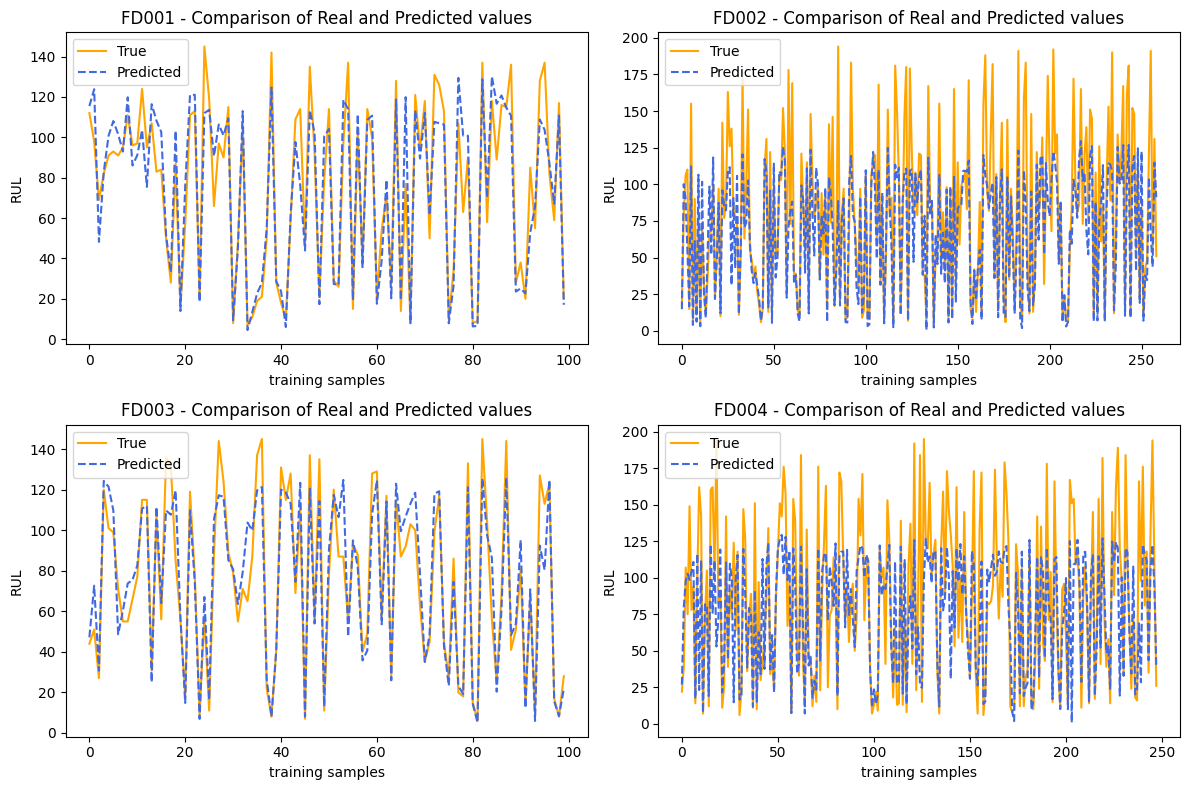

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for idx, (domain, results) in enumerate(all_results.items(), 1):
    plt.subplot(2, 2, idx)
    plt.plot(results['true_rul'], label='True', color='orange')
    plt.plot(results['predictions'], label='Predicted', color='royalblue', linestyle='--')
    plt.xlabel('training samples')
    plt.ylabel('RUL')
    plt.title(f'{domain} - Comparison of Real and Predicted values')
    plt.legend()
plt.tight_layout()
plt.show()

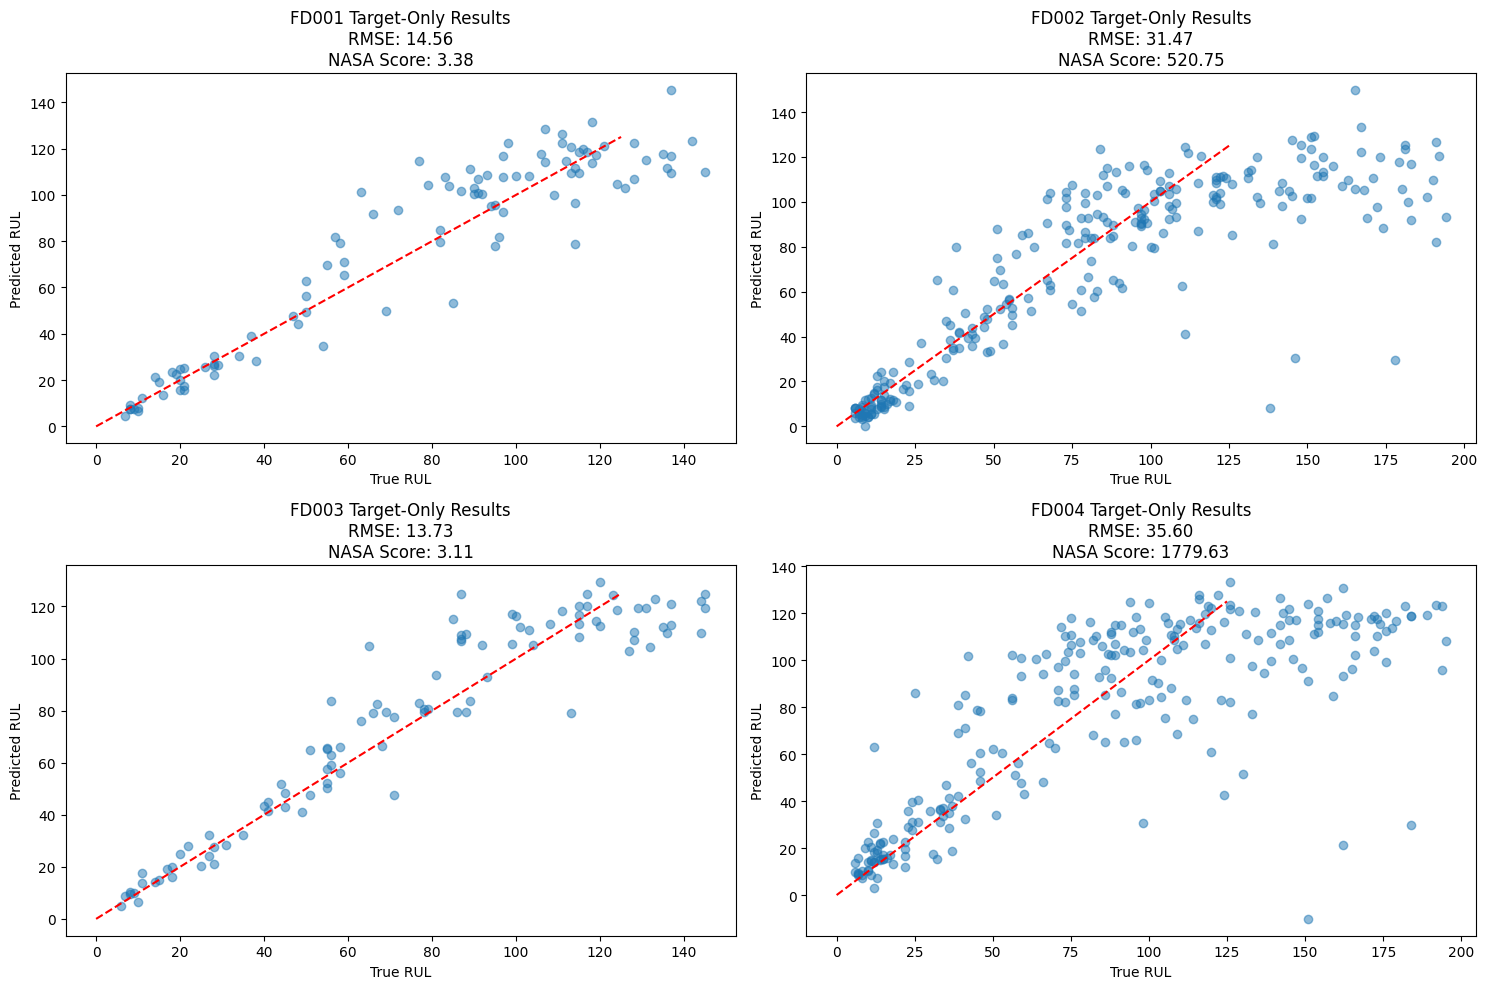

In [ ]:

# Plot results
plt.figure(figsize=(15, 10))
for idx, (domain, results) in enumerate(all_results.items(), 1):
    plt.subplot(2, 2, idx)
    plt.scatter(results['true_rul'], results['predictions'], alpha=0.5)
    plt.plot([0, 125], [0, 125], 'r--')
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'{domain} Target-Only Results\n'
                f'RMSE: {results["rmse"]:.2f}\n'
                f'NASA Score: {results["nasa_score"]:.2f}')
plt.tight_layout()
plt.show()

#### Experiment 2 - Cross Domain using baseline Batch Norm LSTM


  - Train on FD004_train
  - Evaluate ground truth RUL values on the official test on FD002_test, FD003_test, FD004_test.

In [ ]:
# same baseline LSTM regressor with BatchNorm on the hidden state
class LstmRegressorBN(nn.Module):
    def __init__(self, input_dim, hidden=100, n_layers=1, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.bn = nn.BatchNorm1d(hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, 30),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(30, 1)
        )

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        hidden = h_n[-1]             
        hidden_bn = self.bn(hidden)  
        out = self.head(hidden_bn)   
        return out.squeeze(1)        


source_domain = 'FD004'
train_loader = dataloaders[source_domain]['train']
val_loader   = dataloaders[source_domain]['val']

device = "cuda" if torch.cuda.is_available() else "cpu"
sample_x, _, _ = next(iter(train_loader))
input_dim = sample_x.shape[-1]

model = LstmRegressorBN(input_dim=input_dim,
                        hidden=100,
                        n_layers=1,
                        dropout=0.5).to(device)

criterion = nn.L1Loss()  # MAE
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,
                              patience=5,
                              verbose=True)

# Training loop
best_rmse = float('inf')
patience = 20
stall = 0
n_epochs = 100

for epoch in range(1, n_epochs + 1):
    
    model.train()
    for xb, yb, _ in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb, _ in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu()
            all_preds.append(preds)
            all_targets.append(yb)
    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    rmse = torch.sqrt(torch.mean((preds - targets) ** 2)).item()
    print(f"Epoch {epoch:03d} | Val RMSE: {rmse:.3f}")

    scheduler.step(rmse)

    if rmse < best_rmse:
        best_rmse, stall = rmse, 0
        torch.save(model.state_dict(), f"best_{source_domain}_baseline_bn.pt")
    else:
        stall += 1
        if stall >= patience:
            print("Early stopping triggered.")
            break

# Load best model for test evaluation when ready
model.load_state_dict(torch.load(f"best_{source_domain}_baseline_bn.pt", map_location=device))
model.eval()



c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 70.297
Epoch 002 | Val RMSE: 67.118
Epoch 003 | Val RMSE: 54.085
Epoch 004 | Val RMSE: 30.465
Epoch 005 | Val RMSE: 32.234
Epoch 006 | Val RMSE: 31.651
Epoch 007 | Val RMSE: 25.562
Epoch 008 | Val RMSE: 27.659
Epoch 009 | Val RMSE: 38.670
Epoch 010 | Val RMSE: 48.939
Epoch 011 | Val RMSE: 36.152
Epoch 012 | Val RMSE: 25.503
Epoch 013 | Val RMSE: 23.823
Epoch 014 | Val RMSE: 23.420
Epoch 015 | Val RMSE: 25.168
Epoch 016 | Val RMSE: 24.546
Epoch 017 | Val RMSE: 24.974
Epoch 018 | Val RMSE: 24.132
Epoch 019 | Val RMSE: 22.769
Epoch 020 | Val RMSE: 22.925
Epoch 021 | Val RMSE: 24.104
Epoch 022 | Val RMSE: 23.074
Epoch 023 | Val RMSE: 23.484
Epoch 024 | Val RMSE: 24.992
Epoch 025 | Val RMSE: 26.203
Epoch 026 | Val RMSE: 21.717
Epoch 027 | Val RMSE: 22.441
Epoch 028 | Val RMSE: 22.582
Epoch 029 | Val RMSE: 23.737
Epoch 030 | Val RMSE: 23.421
Epoch 031 | Val RMSE: 21.623
Epoch 032 | Val RMSE: 21.499
Epoch 033 | Val RMSE: 25.462
Epoch 034 | Val RMSE: 23.738
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\3380915900.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{source_domain}_bas

LstmRegressorBN(
  (lstm): LSTM(24, 100, batch_first=True)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Sequential(
    (0): Linear(in_features=100, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [ ]:
def evaluate_model_on_test(model_path, domains=['FD001', 'FD002', 'FD003', 'FD004'], 
                          batch_size=256, window_size=30, device='cuda'):
    """
    Evaluates a trained model checkpoint on multiple test domains and displays results in table format.
    """
    results = {}
    
    # Extract SOURCE domain from model path (e.g., 'FD004' from 'best_FD004_baseline_bn.pt')
    source_domain = model_path.split('_')[1] if '_' in model_path else 'FD004'
    
    # Use SOURCE domain scaler and features (the ones model was trained with)
    scaler = globals()[f"scaler_{source_domain[-3:]}"]
    feature_cols = globals()[f"feat_cols_{source_domain[-3:]}"]
    
    model = LstmRegressorBN(input_dim=len(feature_cols), hidden=100, n_layers=1, dropout=0.5).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Store results for table
    table_data = []

    for domain in domains:
        print(f"\nEvaluating on {domain}...")
        
        test_df = read_raw(Path("data/") / f"test_{domain}.txt")
        true_rul = np.loadtxt(Path("data/") / f"RUL_{domain}.txt")
        
        test_scaled = test_df.copy()
        test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
        
        print(f"Scaled features range: {test_scaled[feature_cols].min().min():.2f} to {test_scaled[feature_cols].max().max():.2f}")
        
        windows = window_slice(test_scaled, window=window_size, 
                             stride=1, feature_cols=feature_cols, 
                             target_col=None)
        
        units = windows['domain']
        unique_units = np.unique(units)
        last_indices = [np.where(units == unit)[0][-1] for unit in unique_units]
        X_last = windows['x'][last_indices]
        
        X_last = torch.FloatTensor(X_last).to(device)
        test_loader = DataLoader(X_last, batch_size=batch_size, shuffle=False)
        
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                pred = model(batch)
                predictions.extend(pred.cpu().numpy())
        predictions = np.array(predictions)
        
        print(f"Predictions range: {predictions.min():.2f} to {predictions.max():.2f}")
        print(f"True RUL range: {true_rul.min():.2f} to {true_rul.max():.2f}")
        
        # Calculate metrics
        mse = np.mean((predictions - true_rul) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(predictions - true_rul))
        
        h = predictions - true_rul
        nasa_score = np.mean(np.where(h < 0, np.exp(-h/13) - 1, np.exp(h/10) - 1))
        
        results[domain] = {
            'RMSE': rmse,
            'MAE': mae,
            'NASA Score': nasa_score,
            'Predictions': predictions,
            'True RUL': true_rul
        }
        
        table_data.append([f"{source_domain} → {domain}", f"{rmse:.3f}", f"{nasa_score:.2e}"])

    #  results table
    print("\nCross Domain Results Table:")
    print("| Source → Target | SOURCE-ONLY RMSE |   NASA Score   |")
    print("| --------------- | ---------------- | -------------- |")
    for source_target, rmse, nasa_score in table_data:
        print(f"| {source_target:<15} | {rmse:>16} | {nasa_score:>14} |")

    return results

# Run evaluation 
results = evaluate_model_on_test(
    model_path="best_FD004_baseline_bn.pt",  
    domains=['FD001', 'FD002', 'FD003', 'FD004']
)

C:\Users\House\AppData\Local\Temp\ipykernel_25400\1008217501.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d


Evaluating on FD001...
Scaled features range: -0.00 to 1.00
Predictions range: 16.70 to 169.90
True RUL range: 7.00 to 145.00

Evaluating on FD002...
Scaled features range: -0.00 to 1.00
Predictions range: 4.99 to 130.03
True RUL range: 6.00 to 194.00

Evaluating on FD003...
Scaled features range: -0.00 to 1.00
Predictions range: 15.79 to 167.10
True RUL range: 6.00 to 145.00

Evaluating on FD004...
Scaled features range: -0.00 to 1.00
Predictions range: -1.37 to 130.65
True RUL range: 6.00 to 195.00

Cross Domain Results Table:
| Source → Target | SOURCE-ONLY RMSE |   NASA Score   |
| --------------- | ---------------- | -------------- |
| FD004 → FD001   |           50.981 |       9.83e+02 |
| FD004 → FD002   |           31.909 |       1.08e+03 |
| FD004 → FD003   |           50.771 |       8.20e+02 |
| FD004 → FD004   |           35.782 |       1.34e+03 |


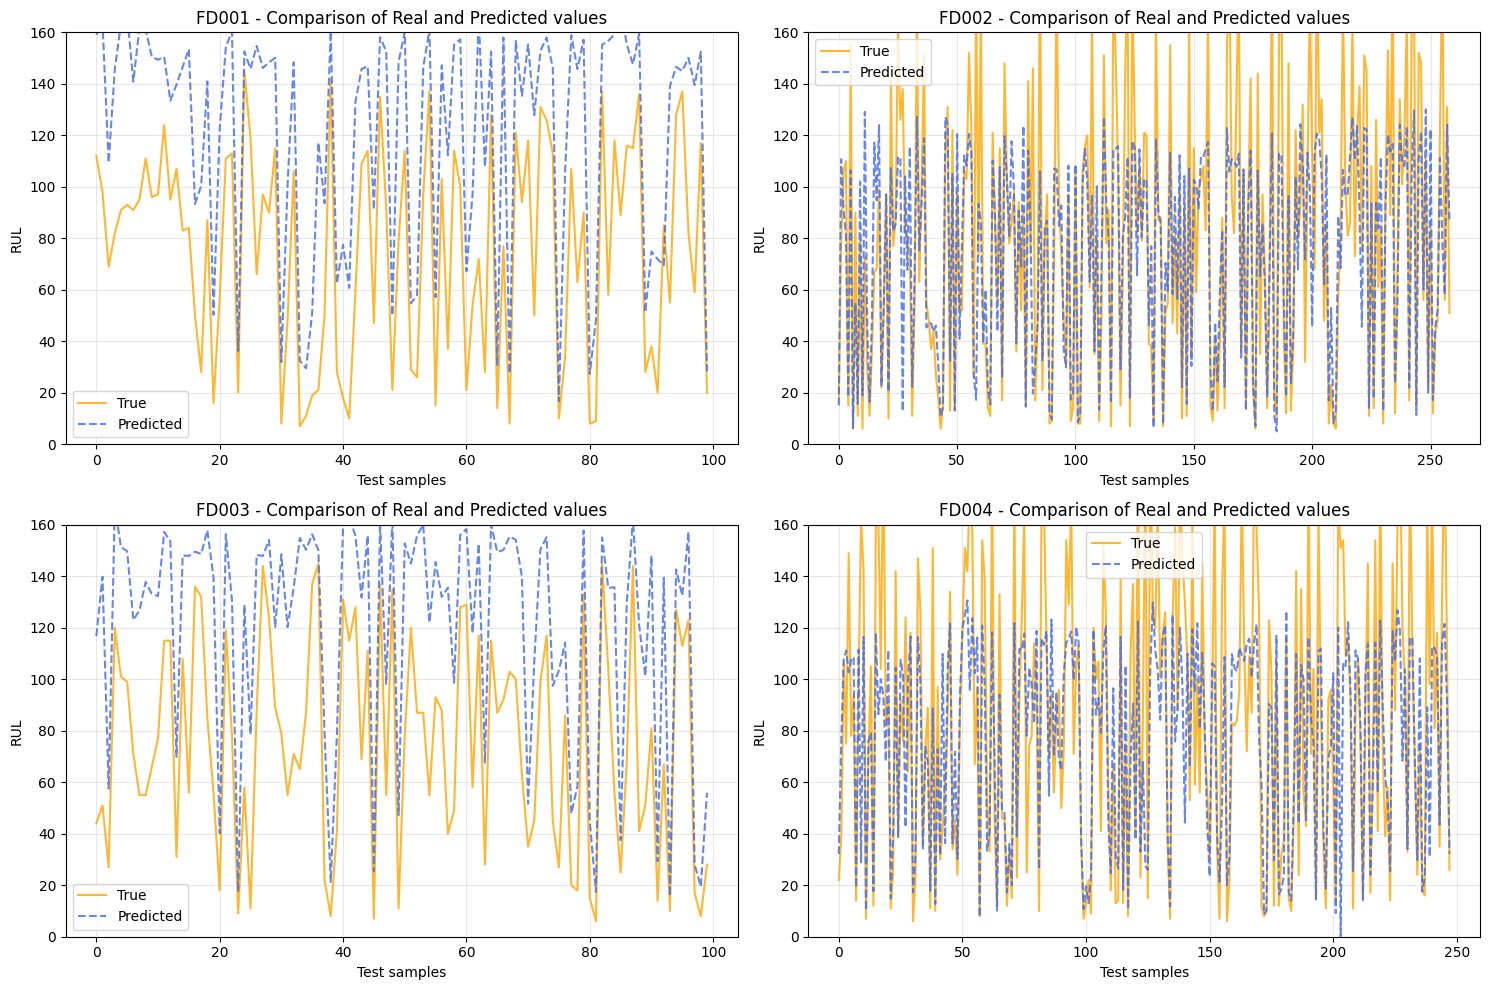

In [ ]:
plt.figure(figsize=(15, 10))
for idx, (domain, metrics) in enumerate(results.items(), 1):
    plt.subplot(2, 2, idx)
    
    samples = range(len(metrics['Predictions']))
    
    plt.plot(samples, metrics['True RUL'], 
             label='True', color='orange', linewidth=1.5, alpha=0.8)
    plt.plot(samples, metrics['Predictions'], 
             label='Predicted', color='royalblue', linewidth=1.5, alpha=0.8, linestyle='--')
    
    plt.xlabel('Test samples')
    plt.ylabel('RUL')
    plt.title(f'{domain} - Comparison of Real and Predicted values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 160)

plt.tight_layout()
plt.show()

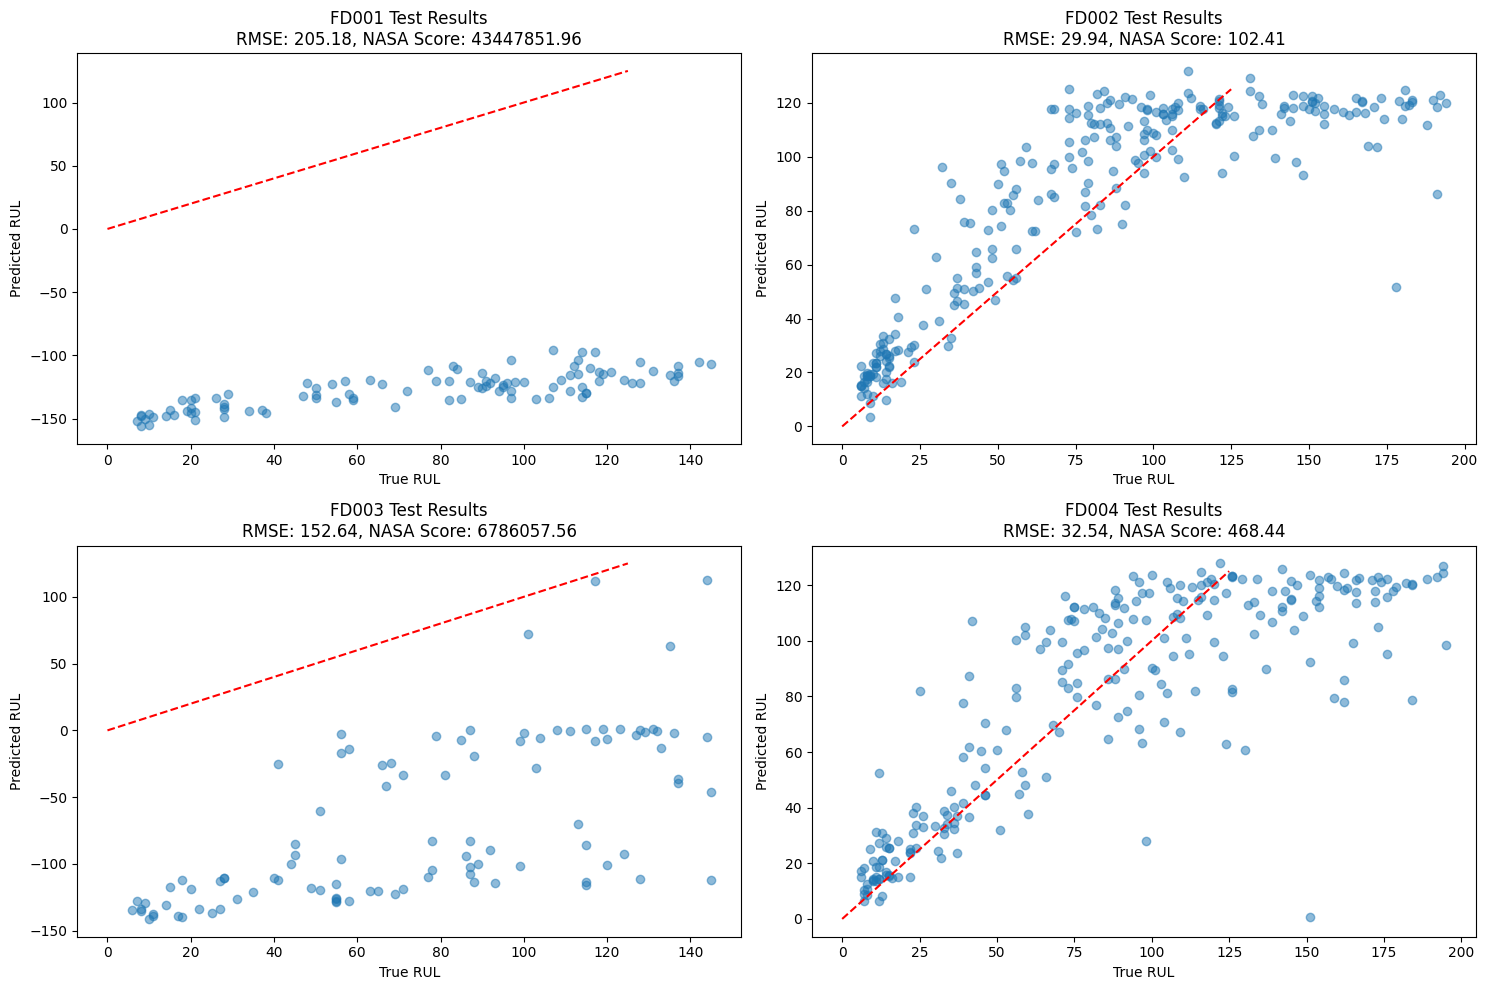

In [ ]:
plt.figure(figsize=(15, 10))
for idx, (domain, metrics) in enumerate(results.items(), 1):
    plt.subplot(2, 2, idx)
    plt.scatter(metrics['True RUL'], metrics['Predictions'], alpha=0.5)
    plt.plot([0, 125], [0, 125], 'r--')  
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'{domain} Test Results\nRMSE: {metrics["RMSE"]:.2f}, NASA Score: {metrics["NASA Score"]:.2f}')
plt.tight_layout()
plt.show()

# Experiment 3 - DANN LSTM

## GradientReversal layer

In [ ]:
class GradientReversal(torch.autograd.Function):
    """
    Gradient Reversal Layer from:
    Ganin & Lempitsky, 'Unsupervised Domain Adaptation by Backpropagation', 2015
    
    Forward pass is identity function, backward pass multiplies gradient by -λ.
    """
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GRL(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
        
    def forward(self, x):
        return GradientReversal.apply(x, self.lambda_)

## DANN-LSTM model

In [ ]:
class LstmDANN(nn.Module):
    def __init__(self, input_dim, hidden=156, n_layers=2, dropout=0.3):
        super().__init__()
        self.encoder = nn.LSTM(
            input_dim, 
            hidden, 
            n_layers,
            batch_first=True,
            bidirectional=True,  
            dropout=dropout if n_layers > 1 else 0
        )
        
        hidden_size = hidden * 2
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
        # Domain classifier through GRL
        self.grl = GRL(lambda_=1.0)
        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        features = torch.cat((h_n[-2], h_n[-1]), dim=1)
        
        # Task prediction
        rul_pred = self.regressor(features).squeeze(1)
        
        # Domain prediction
        domain_pred = self.domain_classifier(self.grl(features)).squeeze(1)
        
        return rul_pred, domain_pred

## Training function with domain adaptation

In [ ]:
def train_dann(source_domain='FD004', target_domain='FD001', n_epochs=100, 
               batch_size=256, learning_rate=1e-3, device='cuda'):
    """
    Train LSTM-DANN model using source labeled data and target unlabeled data.
    """
    Path("checkpoints").mkdir(exist_ok=True)
    ckpt_path = f"checkpoints/best_{source_domain}_to_{target_domain}_dann.pt"
    
    # Get source and target dataloaders
    src_loader = dataloaders[source_domain]['train']
    tgt_loader = dataloaders[target_domain]['train']
    val_loader = dataloaders[source_domain]['val']
    
    input_dim = next(iter(src_loader))[0].shape[-1]
    model = LstmDANN(input_dim=input_dim, hidden=128, 
                     n_layers=2, dropout=0.5).to(device)
    
    regression_criterion = nn.L1Loss()
    domain_criterion = nn.BCELoss()
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                 patience=5, verbose=True)
    
    best_val_rmse = float('inf')
    patience = 20
    stall = 0
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        
        # Calculate alpha for gradient reversal
        alpha = min(1.0, epoch / 10)  # Warmup over first 10 epochs
        model.grl.lambda_ = alpha
        
        for (x_s, y_s, _), (x_t, _, _) in zip(src_loader, tgt_loader):
            x_s, y_s = x_s.to(device), y_s.to(device)
            x_t = x_t.to(device)
            
            # Combine source and target data
            x_combined = torch.cat([x_s, x_t], dim=0)
            domain_y = torch.cat([
                torch.zeros(x_s.shape[0]),
                torch.ones(x_t.shape[0])
            ]).to(device)
            
            optimizer.zero_grad()
            rul_pred, domain_pred = model(x_combined)
            
            rul_loss = regression_criterion(
                rul_pred[:x_s.shape[0]], y_s
            )
            domain_loss = domain_criterion(domain_pred, domain_y)
            
            # Total loss
            loss = rul_loss - alpha * domain_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for x_val, y_val, _ in val_loader:
                rul_pred, _ = model(x_val.to(device))
                val_preds.append(rul_pred.cpu())
                val_targets.append(y_val)
        
        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)
        val_rmse = torch.sqrt(torch.mean((val_preds - val_targets) ** 2))
        
        print(f"Epoch {epoch:03d} | Val RMSE: {val_rmse:.3f}")
        scheduler.step(val_rmse)
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            stall = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            stall += 1
            if stall >= patience:
                print("Early stopping triggered.")
                break
    
    return ckpt_path

## Evaluation function

In [ ]:
def evaluate_dann(source_domain, target_domains, model_path):
    """
    Evaluate DANN model on multiple target domains.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LstmDANN(input_dim=24, hidden=128, n_layers=2, dropout=0.5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    results = []
    
    for target in target_domains:
        test_df = read_raw(Path("data/") / f"test_{target}.txt")
        true_rul = np.loadtxt(Path("data/") / f"RUL_{target}.txt")
        
        # Scale using source domain scaler
        scaler = globals()[f"scaler_{source_domain[-3:]}"]
        feature_cols = globals()[f"feat_cols_{source_domain[-3:]}"]
        
        test_scaled = test_df.copy()
        test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
        
        windows = window_slice(test_scaled, window=30, 
                             stride=1, feature_cols=feature_cols)
        
        units = windows['domain']
        unique_units = np.unique(units)
        last_indices = [np.where(units == unit)[0][-1] for unit in unique_units]
        X_last = windows['x'][last_indices]
        
        X_last = torch.FloatTensor(X_last).to(device)
        with torch.no_grad():
            predictions, _ = model(X_last)
            predictions = predictions.cpu().numpy()
        
        rmse = np.sqrt(np.mean((predictions - true_rul) ** 2))
        results.append([f"{source_domain} → {target}", f"{rmse:.3f}"])
    
    print("\n| Source → Target | LSTM-DANN RMSE |")
    print("| -------------- | -------------- |")
    for row in results:
        print(f"| {row[0]:<14} | {row[1]:>12} |")
    
    return results

## experiment run

In [ ]:
source = "FD004"
targets = ["FD001", "FD002", "FD003", "FD004"]

for target in targets:
    print(f"\nTraining DANN: {source} → {target}")
    model_path = train_dann(source, target)
    
    evaluate_dann(source, [target], model_path)


Training DANN: FD004 → FD001


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 93.054
Epoch 002 | Val RMSE: 89.999
Epoch 003 | Val RMSE: 89.400
Epoch 004 | Val RMSE: 86.002
Epoch 005 | Val RMSE: 79.856
Epoch 006 | Val RMSE: 75.184
Epoch 007 | Val RMSE: 72.520
Epoch 008 | Val RMSE: 78.952
Epoch 009 | Val RMSE: 85.788
Epoch 010 | Val RMSE: 71.569
Epoch 011 | Val RMSE: 84.351
Epoch 012 | Val RMSE: 68.671
Epoch 013 | Val RMSE: 66.555
Epoch 014 | Val RMSE: 52.752
Epoch 015 | Val RMSE: 55.137
Epoch 016 | Val RMSE: 55.212
Epoch 017 | Val RMSE: 46.364
Epoch 018 | Val RMSE: 60.334
Epoch 019 | Val RMSE: 44.087
Epoch 020 | Val RMSE: 59.766
Epoch 021 | Val RMSE: 33.598
Epoch 022 | Val RMSE: 31.884
Epoch 023 | Val RMSE: 26.711
Epoch 024 | Val RMSE: 24.483
Epoch 025 | Val RMSE: 48.473
Epoch 026 | Val RMSE: 23.607
Epoch 027 | Val RMSE: 37.026
Epoch 028 | Val RMSE: 33.565
Epoch 029 | Val RMSE: 23.273
Epoch 030 | Val RMSE: 24.727
Epoch 031 | Val RMSE: 23.131
Epoch 032 | Val RMSE: 24.258
Epoch 033 | Val RMSE: 23.986
Epoch 034 | Val RMSE: 22.695
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\824349771.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
c:\Users\House\

Epoch 001 | Val RMSE: 93.286
Epoch 002 | Val RMSE: 91.947
Epoch 003 | Val RMSE: 56.742
Epoch 004 | Val RMSE: 71.065
Epoch 005 | Val RMSE: 96.965
Epoch 006 | Val RMSE: 94.342
Epoch 007 | Val RMSE: 40.236
Epoch 008 | Val RMSE: 96.811
Epoch 009 | Val RMSE: 56.798
Epoch 010 | Val RMSE: 47.377
Epoch 011 | Val RMSE: 53.703
Epoch 012 | Val RMSE: 34.452
Epoch 013 | Val RMSE: 50.964
Epoch 014 | Val RMSE: 40.464
Epoch 015 | Val RMSE: 36.916
Epoch 016 | Val RMSE: 70.459
Epoch 017 | Val RMSE: 30.343
Epoch 018 | Val RMSE: 32.285
Epoch 019 | Val RMSE: 32.260
Epoch 020 | Val RMSE: 27.422
Epoch 021 | Val RMSE: 37.792
Epoch 022 | Val RMSE: 24.354
Epoch 023 | Val RMSE: 25.410
Epoch 024 | Val RMSE: 34.587
Epoch 025 | Val RMSE: 45.109
Epoch 026 | Val RMSE: 33.935
Epoch 027 | Val RMSE: 42.378
Epoch 028 | Val RMSE: 26.061
Epoch 029 | Val RMSE: 29.665
Epoch 030 | Val RMSE: 22.036
Epoch 031 | Val RMSE: 23.878
Epoch 032 | Val RMSE: 22.320
Epoch 033 | Val RMSE: 27.102
Epoch 034 | Val RMSE: 21.426
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\824349771.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



| Source → Target | LSTM-DANN RMSE |
| -------------- | -------------- |
| FD004 → FD002  |       33.026 |

Training DANN: FD004 → FD003


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 92.158
Epoch 002 | Val RMSE: 88.156
Epoch 003 | Val RMSE: 97.645
Epoch 004 | Val RMSE: 86.893
Epoch 005 | Val RMSE: 59.717
Epoch 006 | Val RMSE: 88.576
Epoch 007 | Val RMSE: 71.021
Epoch 008 | Val RMSE: 96.854
Epoch 009 | Val RMSE: 63.172
Epoch 010 | Val RMSE: 59.085
Epoch 011 | Val RMSE: 51.879
Epoch 012 | Val RMSE: 35.823
Epoch 013 | Val RMSE: 73.950
Epoch 014 | Val RMSE: 26.776
Epoch 015 | Val RMSE: 79.284
Epoch 016 | Val RMSE: 45.373
Epoch 017 | Val RMSE: 23.224
Epoch 018 | Val RMSE: 24.634
Epoch 019 | Val RMSE: 27.004
Epoch 020 | Val RMSE: 24.002
Epoch 021 | Val RMSE: 24.160
Epoch 022 | Val RMSE: 24.965
Epoch 023 | Val RMSE: 45.977
Epoch 024 | Val RMSE: 29.839
Epoch 025 | Val RMSE: 22.032
Epoch 026 | Val RMSE: 24.610
Epoch 027 | Val RMSE: 23.206
Epoch 028 | Val RMSE: 23.580
Epoch 029 | Val RMSE: 33.229
Epoch 030 | Val RMSE: 22.800
Epoch 031 | Val RMSE: 27.490
Epoch 032 | Val RMSE: 22.238
Epoch 033 | Val RMSE: 27.710
Epoch 034 | Val RMSE: 25.433
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\824349771.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



| Source → Target | LSTM-DANN RMSE |
| -------------- | -------------- |
| FD004 → FD003  |       28.545 |

Training DANN: FD004 → FD004


c:\Users\House\anaconda3\envs\rul\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Val RMSE: 90.185
Epoch 002 | Val RMSE: 80.525
Epoch 003 | Val RMSE: 68.477
Epoch 004 | Val RMSE: 64.079
Epoch 005 | Val RMSE: 33.221
Epoch 006 | Val RMSE: 27.239
Epoch 007 | Val RMSE: 31.258
Epoch 008 | Val RMSE: 34.285
Epoch 009 | Val RMSE: 22.733
Epoch 010 | Val RMSE: 22.831
Epoch 011 | Val RMSE: 26.732
Epoch 012 | Val RMSE: 31.069
Epoch 013 | Val RMSE: 36.544
Epoch 014 | Val RMSE: 21.752
Epoch 015 | Val RMSE: 46.669
Epoch 016 | Val RMSE: 24.240
Epoch 017 | Val RMSE: 39.528
Epoch 018 | Val RMSE: 36.634
Epoch 019 | Val RMSE: 35.058
Epoch 020 | Val RMSE: 31.348
Epoch 021 | Val RMSE: 21.279
Epoch 022 | Val RMSE: 19.863
Epoch 023 | Val RMSE: 21.961
Epoch 024 | Val RMSE: 20.262
Epoch 025 | Val RMSE: 24.647
Epoch 026 | Val RMSE: 20.792
Epoch 027 | Val RMSE: 20.614
Epoch 028 | Val RMSE: 31.605
Epoch 029 | Val RMSE: 22.007
Epoch 030 | Val RMSE: 19.748
Epoch 031 | Val RMSE: 19.594
Epoch 032 | Val RMSE: 21.454
Epoch 033 | Val RMSE: 21.867
Epoch 034 | Val RMSE: 19.222
Epoch 035 | Va

C:\Users\House\AppData\Local\Temp\ipykernel_25400\824349771.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



| Source → Target | LSTM-DANN RMSE |
| -------------- | -------------- |
| FD004 → FD004  |       36.674 |


# 5. Evaluation
- Evaluate DANN using RMSE and NASA score.
- Visualize predictions vs. ground truth.

C:\Users\House\AppData\Local\Temp\ipykernel_25400\3163846401.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



FD004 → FD001:
RMSE: 34.559
NASA Score: 3.74e+02

FD004 → FD002:
RMSE: 29.674
NASA Score: 5.19e+01

FD004 → FD003:
RMSE: 34.620
NASA Score: 1.86e+02

FD004 → FD004:
RMSE: 31.932
NASA Score: 4.95e+01


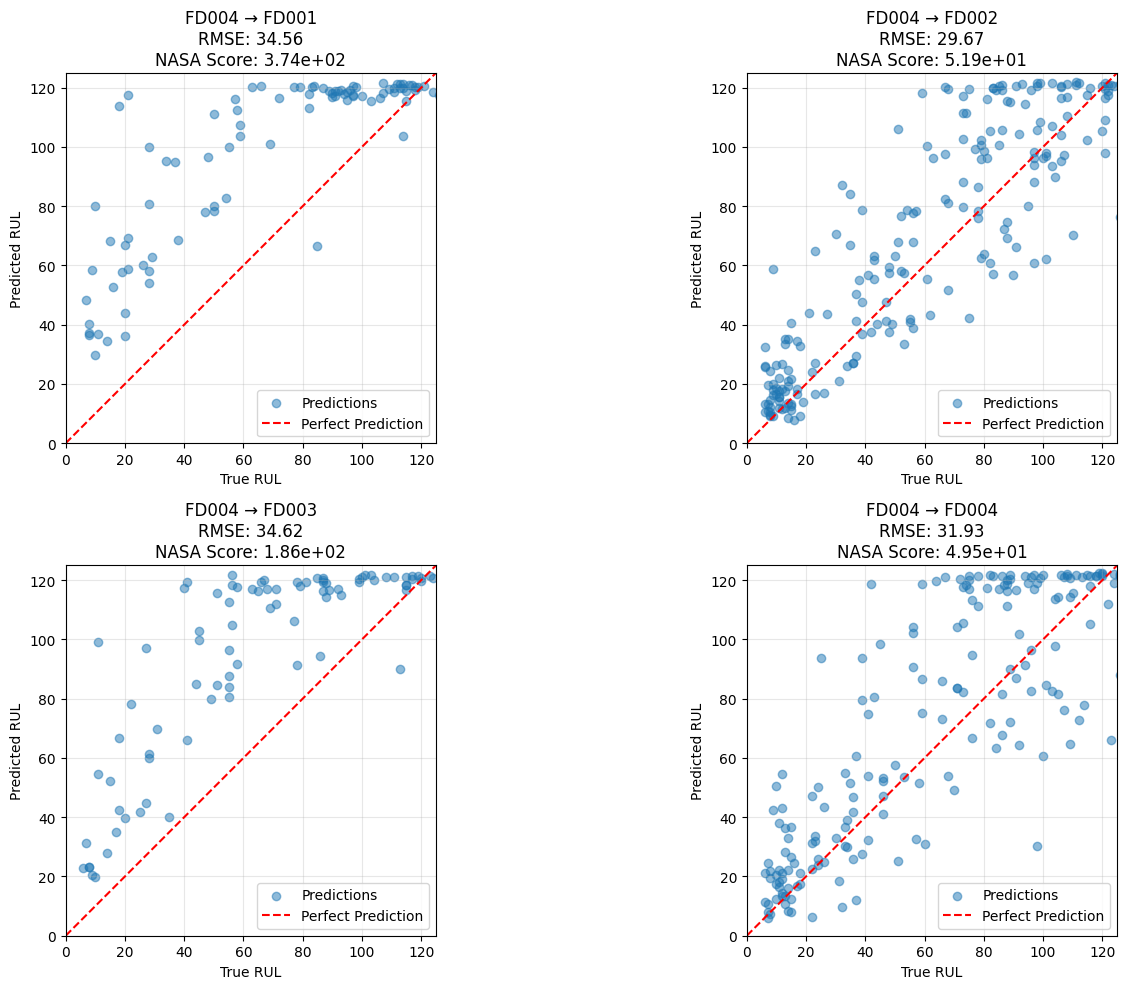

In [ ]:
def evaluate_dann(source_domain, target_domains, model_path):
    """
    Evaluate DANN model on multiple target domains with NASA score and plots.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LstmDANN(input_dim=24, hidden=128, n_layers=2, dropout=0.5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    all_results = {}
    
    for target in target_domains:
        test_df = read_raw(Path("data/") / f"test_{target}.txt")
        true_rul = np.loadtxt(Path("data/") / f"RUL_{target}.txt")
        
        # Scale using source domain scaler
        scaler = globals()[f"scaler_{source_domain[-3:]}"]
        feature_cols = globals()[f"feat_cols_{source_domain[-3:]}"]
        
        test_scaled = test_df.copy()
        test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
        
        windows = window_slice(test_scaled, window=30, 
                             stride=1, feature_cols=feature_cols)
        
        units = windows['domain']
        unique_units = np.unique(units)
        last_indices = [np.where(units == unit)[0][-1] for unit in unique_units]
        X_last = windows['x'][last_indices]
        
        X_last = torch.FloatTensor(X_last).to(device)
        with torch.no_grad():
            predictions, _ = model(X_last)
            predictions = predictions.cpu().numpy()
        
        # Calculate metrics
        rmse = np.sqrt(np.mean((predictions - true_rul) ** 2))
        
        h = predictions - true_rul
        nasa_score = np.mean(np.where(h < 0, 
                                    np.exp(-h/13) - 1, 
                                    np.exp(h/10) - 1))
        
        all_results[target] = {
            'predictions': predictions,
            'true_rul': true_rul,
            'rmse': rmse,
            'nasa_score': nasa_score
        }
        
        print(f"\n{source_domain} → {target}:")
        print(f"RMSE: {rmse:.3f}")
        print(f"NASA Score: {nasa_score:.2e}")
    
    plt.figure(figsize=(15, 10))
    for idx, (target, results) in enumerate(all_results.items(), 1):
        plt.subplot(2, 2, idx)
        
        plt.scatter(results['true_rul'], 
                   results['predictions'], 
                   alpha=0.5,
                   label='Predictions')
        
        plt.plot([0, 125], [0, 125], 'r--', 
                label='Perfect Prediction')
        
        plt.xlabel('True RUL')
        plt.ylabel('Predicted RUL')
        plt.title(f'{source_domain} → {target}\n'
                 f'RMSE: {results["rmse"]:.2f}\n'
                 f'NASA Score: {results["nasa_score"]:.2e}')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axis('square')
        plt.xlim(0, 125)
        plt.ylim(0, 125)
    
    plt.tight_layout()
    plt.show()
    
    return all_results

results = evaluate_dann(
    source_domain='FD004',
    target_domains=['FD001', 'FD002', 'FD003', 'FD004'],
    model_path='checkpoints/best_FD004_to_FD001_dann.pt'
)

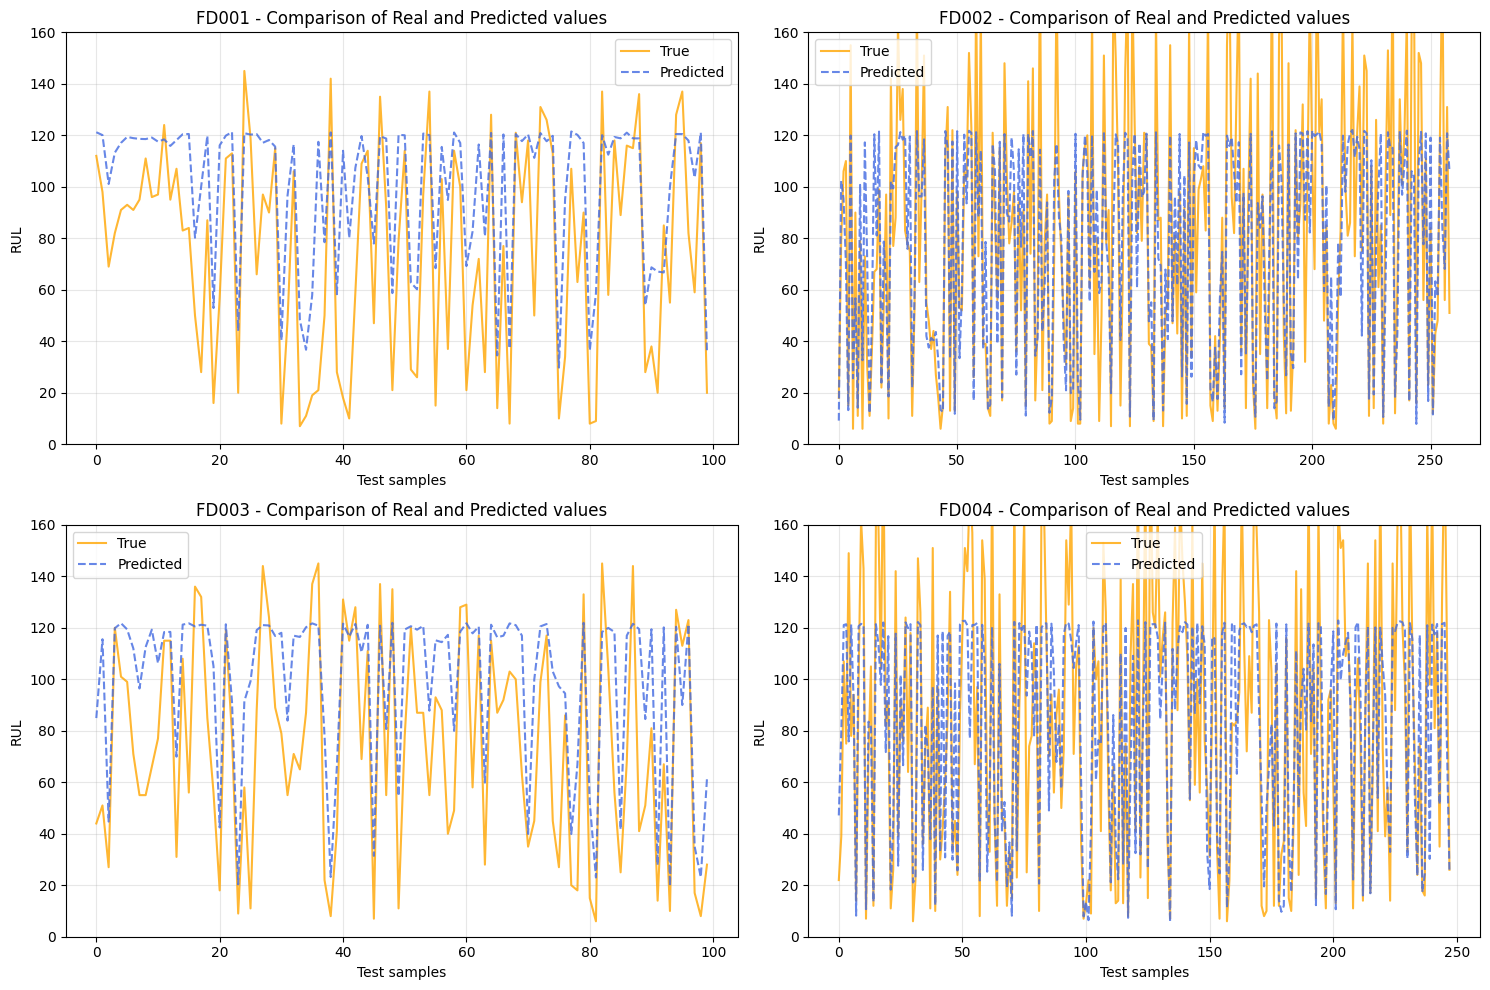

In [ ]:
plt.figure(figsize=(15, 10))
for idx, (domain, metrics) in enumerate(results.items(), 1):
    plt.subplot(2, 2, idx)
    
    samples = range(len(metrics['predictions']))  
    
    plt.plot(samples, metrics['true_rul'],  
             label='True', color='orange', linewidth=1.5, alpha=0.8)
    plt.plot(samples, metrics['predictions'],  
             label='Predicted', color='royalblue', linewidth=1.5, alpha=0.8, linestyle='--')
    
    plt.xlabel('Test samples')
    plt.ylabel('RUL')
    plt.title(f'{domain} - Comparison of Real and Predicted values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 160)

plt.tight_layout()
plt.show()

# 6. Deployment

- This section demonstrates how to use the trained model to predict RUL for new engine data. 
- The model and scaler are loaded, new data is preprocessed, and predictions are generated.

In [59]:
!pip install fastapi uvicorn nest_asyncio joblib


In [ ]:


import nest_asyncio
nest_asyncio.apply()

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
import torch
import joblib
import pandas as pd
from typing import List
from pathlib import Path


MODEL_PATH  = Path("checkpoints/best_FD004_baseline_bn.pt")
SCALER_PATH = Path("checkpoints/scaler_FD004.bin")
FEATURE_COLS = [f"op_{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
WINDOW_SIZE = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LstmRegressorBN(input_dim=len(FEATURE_COLS), hidden=100, n_layers=1, dropout=0.5)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()
scaler = joblib.load(SCALER_PATH)

# FastAPI app ---
app = FastAPI(title="RUL Prediction API", version="1.0")

class TimeSeriesPayload(BaseModel):
    series: List[dict]

@app.get("/")
def health():
    return {"status": "alive"}

@app.post("/predict")
def predict(payload: TimeSeriesPayload):
    df = pd.DataFrame(payload.series)
    missing = set(FEATURE_COLS) - set(df.columns)
    if missing:
        raise HTTPException(status_code=422, detail=f"Missing columns: {missing}")
    df = df[FEATURE_COLS]
    df_scaled = df.copy()
    df_scaled[FEATURE_COLS] = scaler.transform(df[FEATURE_COLS])
    if 'unit' not in df_scaled.columns:
        df_scaled['unit'] = 1
    if 'cycle' not in df_scaled.columns:
        df_scaled['cycle'] = range(1, len(df_scaled) + 1)
    windows = window_slice(df_scaled, window=WINDOW_SIZE, stride=1, feature_cols=FEATURE_COLS)
    if len(windows["x"]) == 0:
        raise HTTPException(status_code=400, detail=f"Need at least {WINDOW_SIZE} time steps for prediction.")
    x_last = torch.Tensor(windows["x"][-1:]).to(device)
    with torch.no_grad():
        pred = model(x_last).cpu().numpy()[0]
    return {"predicted_RUL": float(pred)}




# Run the API in the notebook
uvicorn.run(app, host="0.0.0.0", port=8000)

C:\Users\House\AppData\Local\Temp\ipykernel_25400\2264609273.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=d

# Interpretability of DANN

In [ ]:
!pip install shap

  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------------------------- ---------- 2.1/2.8 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.3 MB/s eta 0:00:00
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   --- ------------------------------------ 2.4/30.3 MB 12.2 MB/s eta 0:00:03
   ------ --------------------------------- 5.0/30.3 MB 12.1 MB/s eta 0:00:03
   -------- ------------------------------- 6.6/30.3 MB 10.9 MB/s eta 0:00:03
   ---------- ----------------------------- 8.1/30.3 MB 9.9 MB/s eta 0:00:03
   ------------ --------------------------- 9.7/30.3 MB 9.6 MB/s eta 0:00:03
   --------------- ------------------------ 1

Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at c:\Users\House\anaconda3\envs\rul\Lib\site-packages\uvicorn\server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "c:\Users\House\anaconda3\envs\rul\Lib\site-packages\uvicorn\main.py", line 580, in run
    server.run()
  File "c:\Users\House\anaconda3\envs\rul\Lib\site-packages\uvicorn\server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\House\anaconda3\envs\rul\Lib\site-packages\nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\House\anaconda3\envs\rul\Lib\site-packages\nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "c:\Users\House\anaconda3\envs\rul\Lib\site-packages\nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "c:\Us

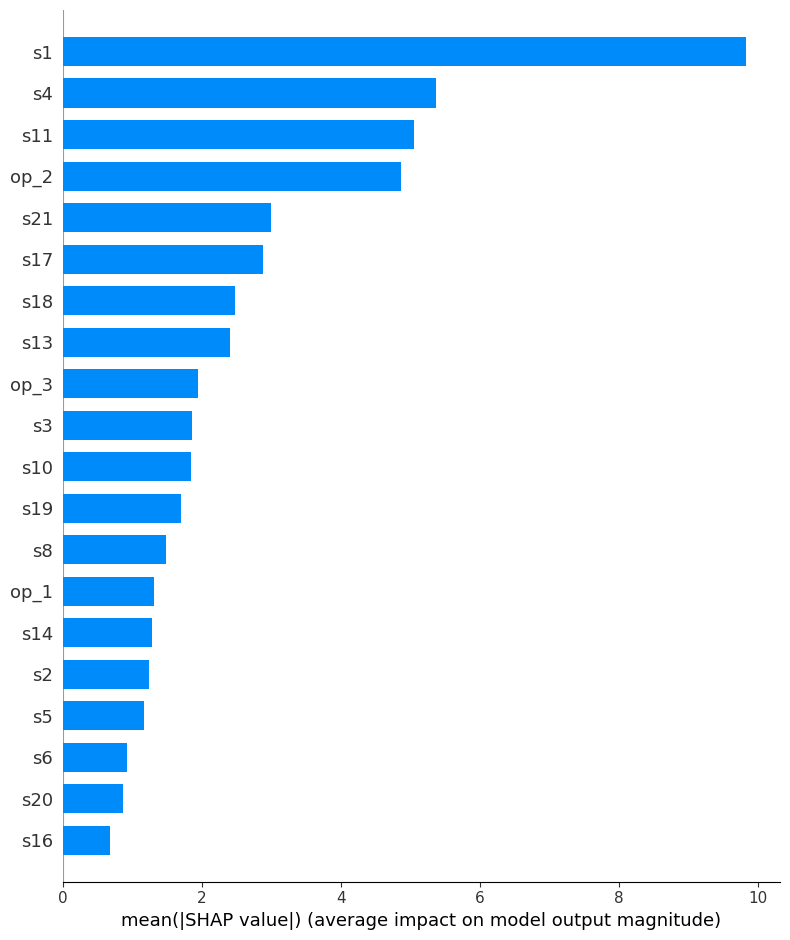


Feature Importance Ranking:
s1: 9.8258
s4: 5.3726
s11: 5.0534
op_2: 4.8669
s21: 2.9977
s17: 2.8778
s18: 2.4780
s13: 2.4042
op_3: 1.9403
s3: 1.8524
s10: 1.8460
s19: 1.6958
s8: 1.4779
op_1: 1.3183
s14: 1.2815
s2: 1.2396
s5: 1.1613
s6: 0.9261
s20: 0.8664
s16: 0.6772
s12: 0.2409
s9: 0.1885
s7: 0.0000
s15: 0.0000


In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# average each window over time steps
feature_names = [f"op_{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
val_data = domain_packs['FD004']['val']['x']  
val_data_avg = val_data.mean(axis=1)          

# prediction function for SHAP 
def predict_fn(x):
    x_torch = torch.FloatTensor(np.repeat(x[:, None, :], 30, axis=1)).to(next(model.parameters()).device)
    with torch.no_grad():
        out = model(x_torch)
        if out.dim() == 2:
            out = out.squeeze(1)
        return out.cpu().numpy()

background = val_data_avg[:100]      # 100 background samples for SHAP
test_samples = val_data_avg[100:105] # 5 samples to explain

# KernelExplainer 
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(test_samples, nsamples=100)

shap.summary_plot(shap_values, test_samples, feature_names=feature_names, plot_type="bar")

mean_importance = np.abs(shap_values).mean(axis=0)
print("\nFeature Importance Ranking:")
for feat, imp in sorted(zip(feature_names, mean_importance), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

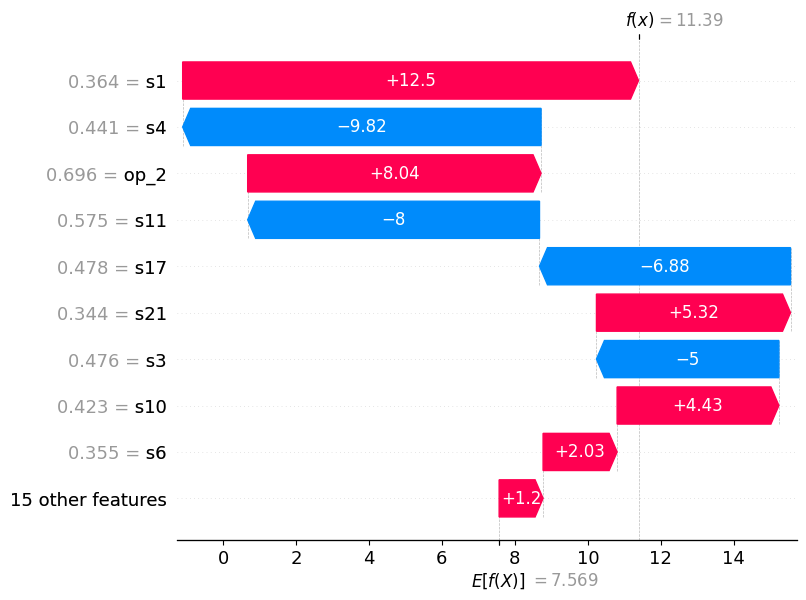

In [62]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=test_samples[0],
        feature_names=feature_names
    )
)

Processing FD001...


100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


Processing FD002...


100%|██████████| 5/5 [00:00<00:00, 36.79it/s]


Processing FD003...


100%|██████████| 5/5 [00:00<00:00, 40.84it/s]


Processing FD004...


100%|██████████| 5/5 [00:00<00:00, 40.79it/s]


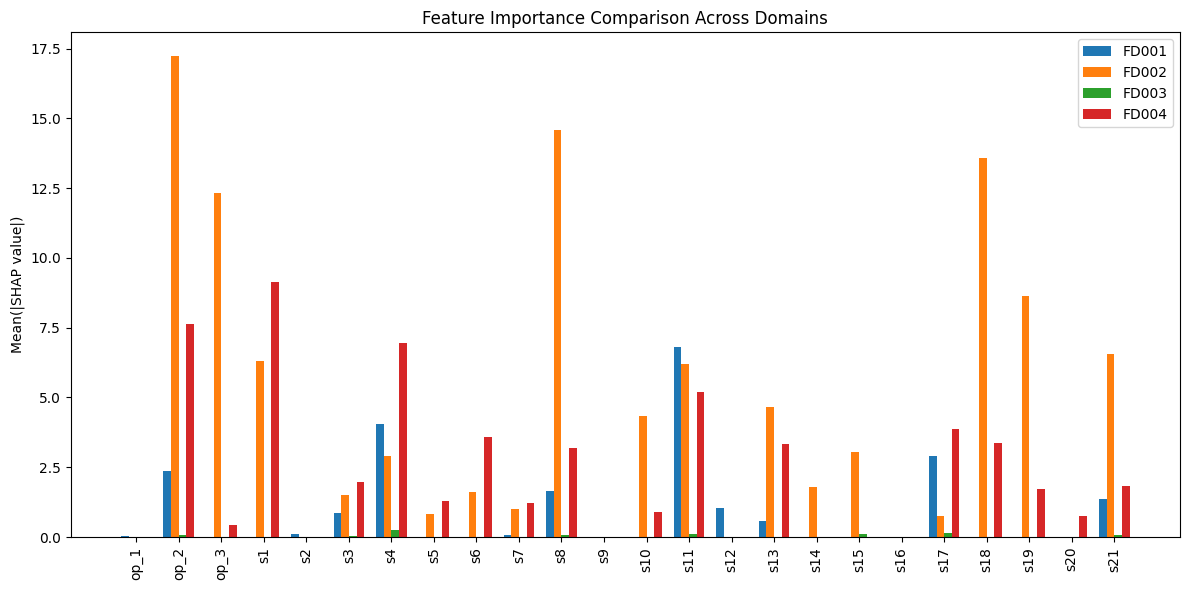

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

domains = ['FD001', 'FD002', 'FD003', 'FD004']
feature_names = [f"op_{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
window_size = 30

domain_shap_means = {}

for domain in domains:
    print(f"Processing {domain}...")
    val_data = domain_packs[domain]['val']['x']  
    val_data_avg = val_data.mean(axis=1)         
    
    def predict_fn(x):
        x_torch = torch.FloatTensor(np.repeat(x[:, None, :], window_size, axis=1)).to(next(model.parameters()).device)
        with torch.no_grad():
            out = model(x_torch)
            if out.dim() == 2:
                out = out.squeeze(1)
            return out.cpu().numpy()
    
    background = val_data_avg[:100]
    test_samples = val_data_avg[100:105]
    
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(test_samples, nsamples=100)
    
    mean_importance = np.abs(shap_values).mean(axis=0)
    domain_shap_means[domain] = mean_importance

plt.figure(figsize=(12, 6))
bar_width = 0.18
indices = np.arange(len(feature_names))

for i, domain in enumerate(domains):
    plt.bar(indices + i * bar_width, domain_shap_means[domain], width=bar_width, label=domain)

plt.xticks(indices + bar_width * (len(domains)-1)/2, feature_names, rotation=90)
plt.ylabel("Mean(|SHAP value|)")
plt.title("Feature Importance Comparison Across Domains")
plt.legend()
plt.tight_layout()
plt.show()